In [2]:
%config Completer.use_jedi = False
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
    
print('Load interaction') 
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]

print('Load high-quality cells only')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = sc.read_h5ad(fn_h5ad)
print('normalize data to CPM (counts per million)')
sc.pp.normalize_total(adata, target_sum=1e6)
        
print('Restrict to interaction genes')
genes = np.unique(interactions)
genes = [i for i in genes if i in adata.var_names] # genes = genes - ['CCL3L3', 'CCL4L1', 'CCN6', 'KIR3DS1', 'YARS1']
adatag = adata[:, genes]

Load interaction
Load high-quality cells only
normalize data to CPM (counts per million)
Restrict to interaction genes


In [18]:
adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']
from adata_utilis import split_adata
print('split adata to [sick/condition, dataset]')
adata_dic = split_adata(adata)

split adata to [sick/condition, dataset]


In [3]:
data_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/data_pair.tsv', sep='\t', index_col=['cell_subtype_2', 'gene'])
data_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/log2_fc.tsv', index_col=['cell_type', 'gene'])
data_ct.drop(['statistic', 'pvalue'], axis=1, inplace=True)
data_ct.columns = data_cst.columns
cst_idx = [(cst, gene) for cst in ['Macrophages', 
                                   'non_classical_monocytes',
                                   'IgA',
                                   'IgG1_proliferate',
                                   'Classical_monocytes',
                                   'IgG1_IgG2','IgG1',
                                   'IgM',] for gene in genes]
data_cst = data_cst.loc[cst_idx]

In [39]:
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]
cts = ['B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']
csts = ['Macrophages', 
        'non_classical_monocytes',
        'IgA',
        'IgG1_proliferate',
        'Classical_monocytes',
        'IgG1_IgG2',
        'IgG1',
        'IgM',]
res = []
for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    if (ga not in genes) | (gb not in genes):
        continue
    for cst in csts:
        cst_med = {gene: data_cst.loc[cst, gene]['med_pair'] for gene in [ga, gb]} 
        cst_fra_pair = {gene: data_cst.loc[cst, gene]['fra_pair'] for gene in [ga, gb]} 
        cst_fra = {(gene, cd): data_cst.loc[cst, gene][cd+'_fra'] for gene in [ga, gb] for cd in ['S', 'NS']}
        for ct in cts:
            ct_med = {gene: data_ct.loc[ct, gene]['med_pair'] for gene in [ga, gb]}
            ct_fra_pair = {gene: data_ct.loc[ct, gene]['fra_pair'] for gene in [ga, gb]}
            ct_fra = {(gene, cd): data_ct.loc[ct, gene][cd+'_fra'] for gene in [ga, gb] for cd in ['S', 'NS']}

            if (cst_med[ga] > 1) & (ct_med[gb] > 1) & (cst_fra[ga, 'S'] > 0.02) & (ct_fra[gb, 'S'] > 0.02):
                res.append([
                    ga, cst, cst_med[ga], cst_fra_pair[ga], cst_fra[ga, 'S'], cst_fra[ga, 'NS'],
                    gb, ct, ct_med[gb], ct_fra_pair[gb], ct_fra[gb, 'S'], ct_fra[gb, 'NS'], 'up'
                ])
            if (cst_med[gb] > 1) & (ct_med[ga] > 1) & (cst_fra[gb, 'S'] > 0.02) & (ct_fra[ga, 'S'] > 0.02):
                res.append([
                    gb, cst, cst_med[gb], cst_fra_pair[gb], cst_fra[gb, 'S'], cst_fra[gb, 'NS'],
                    ga, ct, ct_med[ga], ct_fra_pair[ga], ct_fra[ga, 'S'], ct_fra[ga, 'NS'], 'up'
                ])
            #####################
            if (cst_med[ga] < -1) & (ct_med[gb] < -1) & (cst_fra[ga, 'NS'] > 0.02) & (ct_fra[gb, 'NS'] > 0.02):
                res.append([
                    ga, cst, cst_med[ga], cst_fra_pair[ga], cst_fra[ga, 'S'], cst_fra[ga, 'NS'],
                    gb, ct, ct_med[gb], ct_fra_pair[gb], ct_fra[gb, 'S'], ct_fra[gb, 'NS'], 'down'
                ])
            if (cst_med[gb] < -1) & (ct_med[ga] < -1) & (cst_fra[gb, 'NS'] > 0.02) & (ct_fra[ga, 'NS'] > 0.02):
                res.append([
                    gb, cst, cst_med[gb], cst_fra_pair[gb], cst_fra[gb, 'S'], cst_fra[gb, 'NS'],
                    ga, ct, ct_med[ga], ct_fra_pair[ga], ct_fra[ga, 'S'], ct_fra[ga, 'NS'], 'down'
                ])
            #####################
            if (cst_med[ga] > 1) & (ct_med[gb] < -1) & (cst_fra[ga, 'S'] > 0.02) & (ct_fra[gb, 'NS'] > 0.02):
                res.append([
                    ga, cst, cst_med[ga], cst_fra_pair[ga], cst_fra[ga, 'S'], cst_fra[ga, 'NS'],
                    gb, ct, ct_med[gb], ct_fra_pair[gb], ct_fra[gb, 'S'], ct_fra[gb, 'NS'], 'mix'
                ])
                
            if (cst_med[ga] < -1) & (ct_med[gb] > 1) & (cst_fra[ga, 'NS'] > 0.02) & (ct_fra[gb, 'S'] > 0.02):
                res.append([
                    gb, ct, ct_med[gb], ct_fra_pair[gb], ct_fra[gb, 'S'], ct_fra[gb, 'NS'], 
                    ga, cst, cst_med[ga], cst_fra_pair[ga], cst_fra[ga, 'S'], cst_fra[ga, 'NS'], 'mix'
                ])
                
            if (cst_med[gb] > 1) & (ct_med[ga] < -1) & (cst_fra[gb, 'S'] > 0.02) & (ct_fra[ga, 'NS'] > 0.02):
                res.append([
                    gb, cst, cst_med[gb], cst_fra_pair[gb], cst_fra[gb, 'S'], cst_fra[gb, 'NS'],
                    ga, ct, ct_med[ga], ct_fra_pair[ga], ct_fra[ga, 'S'], ct_fra[ga, 'NS'], 'mix'
                ])
            if (cst_med[gb] < -1) & (ct_med[ga] > 1) & (cst_fra[gb, 'NS'] > 0.02) & (ct_fra[ga, 'S'] > 0.02):
                res.append([
                    ga, ct, ct_med[ga], ct_fra_pair[ga], ct_fra[ga, 'S'], ct_fra[ga, 'NS'], 
                    gb, cst, cst_med[gb], cst_fra_pair[gb], cst_fra[gb, 'S'], cst_fra[gb, 'NS'], 'mix'
                ])

res = pd.DataFrame(res, columns=[
    'ga', 'csta', 'ga_med_pair', 'ga_fra_pair','ga_SD_fra', 'ga_D_fra', 
    'gb', 'cstb', 'gb_med_pair', 'gb_fra_pair','gb_SD_fra', 'gb_D_fra',
    'inter_type'])

In [40]:
res.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/Mo_Pl_cst.tsv', sep='\t')

In [41]:
res

,ga,csta,ga_med_pair,ga_fra_pair,ga_SD_fra,ga_D_fra,gb,cstb,gb_med_pair,gb_fra_pair,gb_SD_avg,gb_D_avg,inter_type
0,CXCR3,IgA,1.058357,0.781250,0.205567,0.162162,CCL19,cDCs,-5.474215,0.000000,0.000000,0.026549,mix
1,CXCR3,IgG1_proliferate,1.106691,0.781250,0.568498,0.334520,CCL19,cDCs,-5.474215,0.000000,0.000000,0.026549,mix
2,CXCR3,IgG1_IgG2,2.302328,0.714286,0.334400,0.327586,CCL19,cDCs,-5.474215,0.000000,0.000000,0.026549,mix
3,CXCR3,IgG1,1.178789,0.785714,0.443459,0.360845,CCL19,cDCs,-5.474215,0.000000,0.000000,0.026549,mix
4,MDK,Macrophages,-1.065906,0.285714,0.021164,0.031746,LRP1,cDCs,-1.656365,0.250000,0.128755,0.115044,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,NAMPT,IgA,2.541867,0.968750,0.098501,0.046683,CCR5,cDCs,2.534717,0.708333,0.060086,0.026549,up
223,NAMPT,IgA,2.541867,0.968750,0.098501,0.046683,CCR5,pDCs,-3.773626,0.000000,0.000000,0.025806,mix
224,NAMPT,IgG1_IgG2,2.019319,0.857143,0.108800,0.066810,CCR5,T_cells,1.468848,0.750000,0.048619,0.029528,up
225,NAMPT,IgG1_IgG2,2.019319,0.857143,0.108800,0.066810,CCR5,cDCs,2.534717,0.708333,0.060086,0.026549,up


In [46]:
def randomization(genes):
    log2fc = defaultdict(list)
    r = defaultdict(list)
    pvalue = {}
    
    for i, inter in enumerate(genes):
        if i % 100 == 0:
            print(i)
        ga = inter['ga']
        cta = inter['cta']
        gb = inter['gb']
        ctb = inter['ctb']
        
        adata_g = {}
        adata_children = adata[adata.obs['dataset'] == 'child']
        
        for gene, ct in zip([ga, gb], [cta, ctb]):
            if ct in adata_children.obs['cell_subtype_2'].unique():
                ct_type = 'cell_subtype_2'
            elif ct in adata_children.obs['cell_type'].unique():
                ct_type = 'cell_type'
            adata_ct = adata_children[adata_children.obs[ct_type] == ct]
            IDs = list(adata_ct.obs['ID'].astype('category').cat.categories)
            for ID in IDs:
                adata_ID = adata_ct[adata_ct.obs['ID'] == ID]
                if len(adata_ID.obs_names) < 5:
                    IDs.remove(ID)
            adata_ct = adata_ct[adata_ct.obs['ID'].isin(IDs)]
            adata_g[gene] = adata_ct[:, gene]  
            
        avg = {(gene, cd): adata_g[gene][adata_g[gene].obs['Condition'] == cd].X.toarray().mean() for gene in [ga, gb] for cd in ['S_dengue', 'dengue']}
        lfc = {gene: np.log2(avg[gene, 'S_dengue'] + 0.1) - np.log2(avg[gene, 'dengue'] + 0.1) for gene in [ga, gb]}
        log2fc[(ga, cta, gb, ctb)].append([lfc[ga], lfc[gb]])
        r0 = (float(lfc[ga])**2 + float(lfc[gb])**2)**0.5
        r[(ga, cta, gb, ctb)].append(r0)
        
        p = 0
        for i in range(1000):
            adata_i = adata_g
            raw = {gene: adata_i[gene].obs['Condition'].tolist() for gene in [ga, gb]}
            for gene in [ga, gb]:
                random.shuffle(raw[gene])
                adata_i[gene].obs['Condition'] = raw[gene]
            avg_i = {(gene, cd): adata_i[gene][adata_i[gene].obs['Condition'] == cd].X.toarray().mean() for gene in [ga, gb] for cd in ['S_dengue', 'dengue']}
            log2fc_i = {gene: np.log2(avg_i[gene, 'S_dengue'] + 0.1) - np.log2(avg_i[gene, 'dengue'] + 0.1) for gene in [ga, gb]}
            log2fc[(ga, cta, gb, ctb)].append([log2fc_i[ga], log2fc_i[gb]])
            ri = (float(log2fc_i[ga])**2 + float(log2fc_i[gb])**2)**0.5
            r[(ga, cta, gb, ctb)].append(ri)
            if ri >= r0:
                p += 1
        pvalue[(ga, cta, gb, ctb)] = p * 0.001

    res = pd.DataFrame([])
    for key in log2fc.keys():
        log2fc[key] = pd.DataFrame(log2fc[key], columns = ['log2fc_ga', 'log2fc_gb'])
        log2fc[key]['r'] = r[key]
        log2fc[key]['pvalue'] = pvalue[key]
        for j, s in enumerate(['ga', 'csta', 'gb', 'cstb']):
            log2fc[key][s] = key[j]
        res = pd.concat([res, log2fc[key]])
    res = res.set_index(['ga', 'csta', 'gb', 'cstb'])
        
    return res

In [181]:
res = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/Mo_Pl_cst.tsv', sep='\t')
res_r = res[
    ((res['ga_fra_pair'] > 0.5) & (res['gb_fra_pair'] > 0.5) & (res['inter_type'] == 'up')) |
    ((res['ga_fra_pair'] < 0.5) & (res['gb_fra_pair'] < 0.5) & (res['inter_type'] == 'down')) |
    ((res['ga_fra_pair'] > 0.5) & (res['gb_fra_pair'] < 0.5) & (res['inter_type'] == 'mix')) 
]
r_genes = [{'ga': ga, 'cta': cta, 'gb': gb, 'ctb': ctb} for ga, cta, gb, ctb in zip(res_r['ga'].tolist(), res_r['csta'].tolist(), res_r['gb'].tolist(), res_r['cstb'].tolist())]
ran_res = randomization(r_genes)
ran_res.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/randomization_inters_Mo&Pl_cst.tsv')

In [90]:
def ran_filter(ran_res, genes):
    sig_res = pd.DataFrame([], columns = ['log2fc_ga', 'log2fc_gb', 'r', 'pvalue', 'ga', 'csta', 'gb', 'cstb'])
    i = 0
    
    for inter in genes:
        ga = inter['ga']
        csta = inter['cta']
        gb = inter['gb']
        cstb = inter['ctb']
        if ran_res.loc[ga, csta, gb, cstb][:1]['pvalue'][0] == 0:
            i += 1
            loc = ran_res.loc[ga, csta, gb, cstb][:1].loc[ga, csta, gb, cstb].tolist()
            for j in [ga, csta, gb, cstb]:
                loc.append(j)
            sig_res.loc[i] = loc
    return sig_res

In [91]:
ran_filter = ran_filter(ran_res, r_genes)
ran_filter.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/ran_filter_inters_Mo&Pl_cst.tsv', sep='\t', index=False)

<ipython-input-90-a565af1a3728>:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  if ran_res.loc[ga, csta, gb, cstb][:1]['pvalue'][0] == 0:
<ipython-input-90-a565af1a3728>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  loc = ran_res.loc[ga, csta, gb, cstb][:1].loc[ga, csta, gb, cstb].tolist()


In [99]:
ran_filter.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
res.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
ran_inters = res.loc[ran_filter.index]
ran_inters.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/pair_filter_inters_Mo&Pl_cst.tsv', sep='\t')

In [169]:
def randomization_plot(fdn, ran_filter, ran_res):
    ran_genes = [{'ga': idx[0], 'cta': idx[1], 'gb': idx[2], 'ctb': idx[3]} for idx in ran_filter.index]
    for inter in ran_genes:
        fig, ax = plt.subplots(figsize=[3, 3], dpi=300)
        ga = inter['ga']
        cta = inter['cta']
        gb = inter['gb']
        ctb = inter['ctb']

        log2fc = ran_res.loc[ga, cta, gb, ctb]

        x0 = log2fc['log2fc_ga'].tolist()[0]
        y0 = log2fc['log2fc_gb'].tolist()[0]    

        x = log2fc['log2fc_ga'].tolist()[1:]
        y = log2fc['log2fc_gb'].tolist()[1:]

        ax.scatter(x0, y0, c='r', s=10)
        ax.scatter(x, y, c='blue', s=2)
        ax.axvline(0, c='gray', zorder=-3, lw=0.5)
        ax.axhline(0, c='gray', zorder=-3, lw=0.5)
        ax.set_ylim(-4, 4)
        ax.set_xlim(-4, 4)
        ax.set_xlabel('Log2fc of ' + ga + ' in ' + cta.replace('_', ' '))
        ax.set_ylabel('Log2fc of ' + gb + ' in ' + ctb.replace('_', ' '))
        p = ran_res.loc[ga, cta, gb, ctb]['pvalue'][0]
        if p == 0:
            ax.set_title('p value < 0.001')
        else:
            ax.set_title('p value: ' + str(p))
        plt.savefig(fdn + ga + '_in_' + cta + '&' + gb + '_in_' + ctb + '.png', bbox_inches = 'tight')
#######################################################################

<ipython-input-169-61d6c2315d76>:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  log2fc = ran_res.loc[ga, cta, gb, ctb]
<ipython-input-169-61d6c2315d76>:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  p = ran_res.loc[ga, cta, gb, ctb]['pvalue'][0]
<ipython-input-169-61d6c2315d76>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=[3, 3], dpi=300)


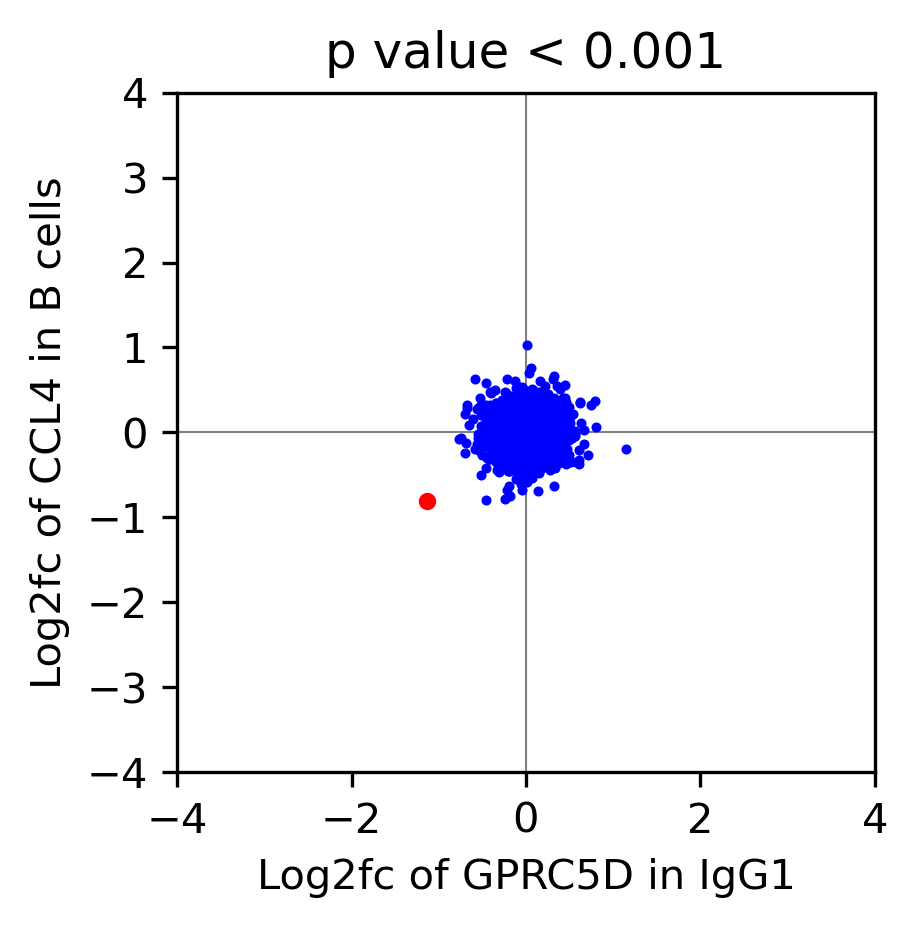

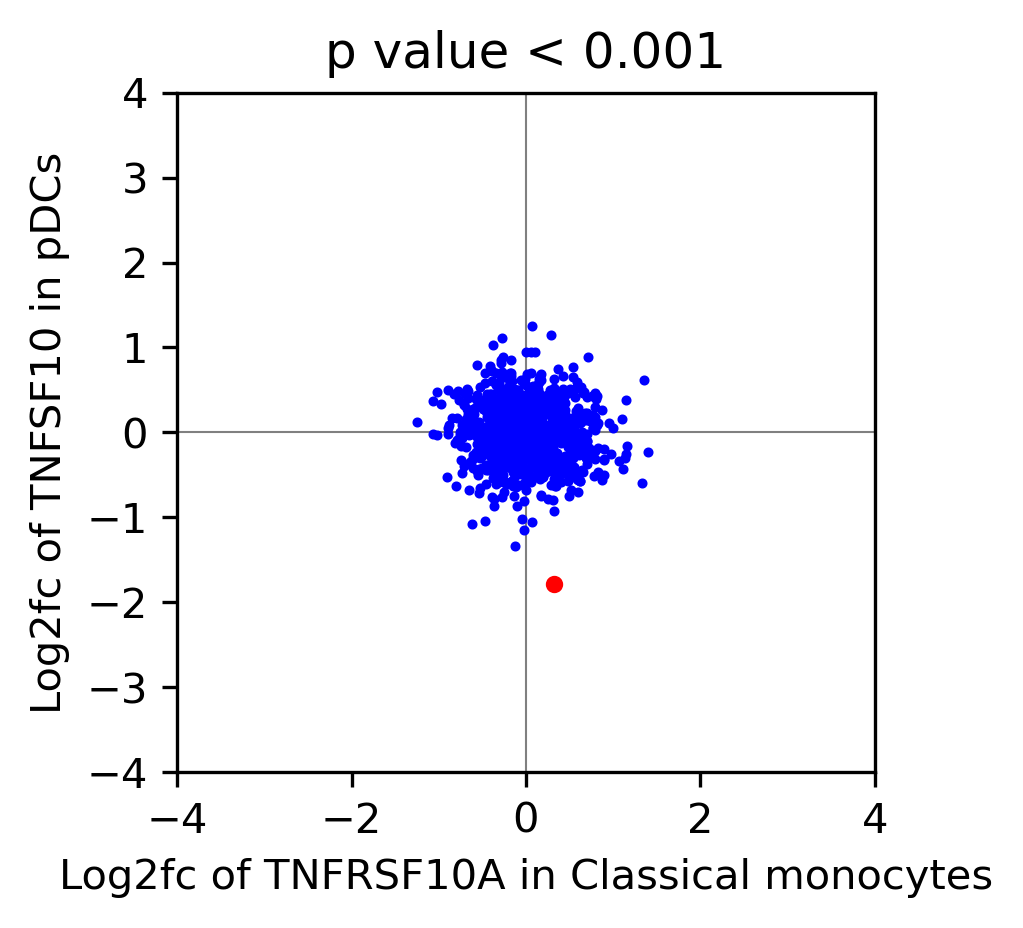

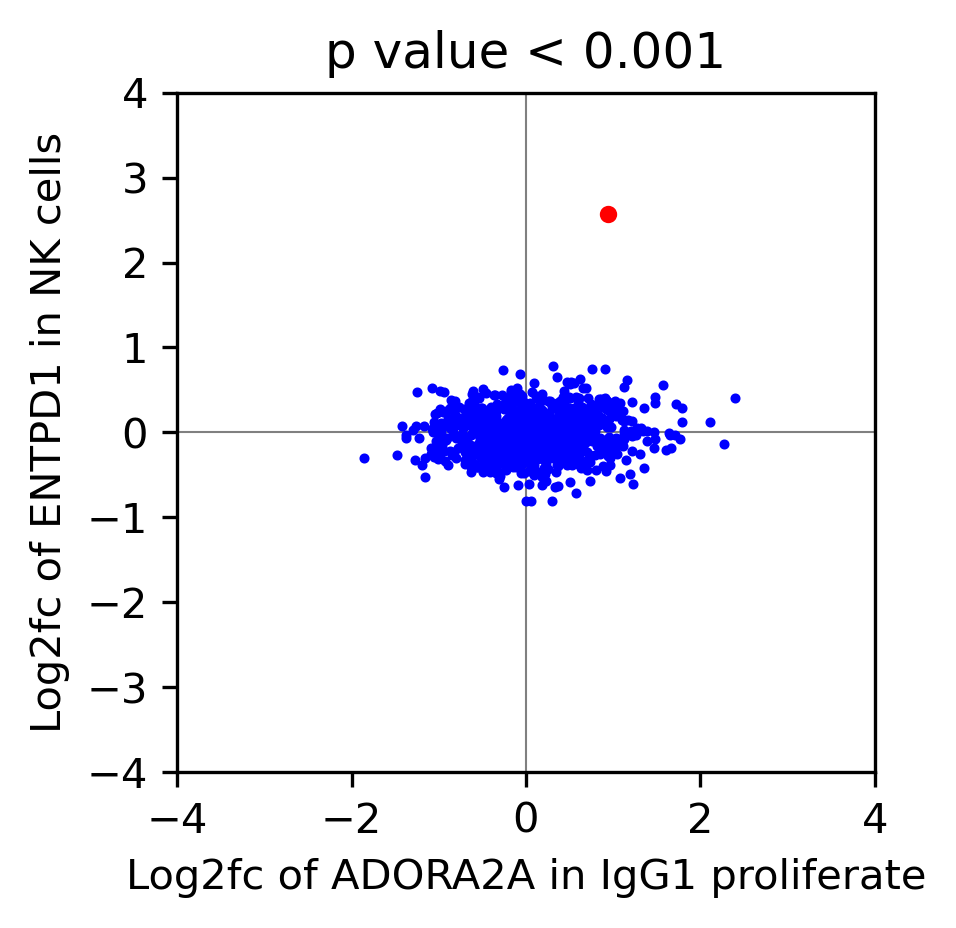

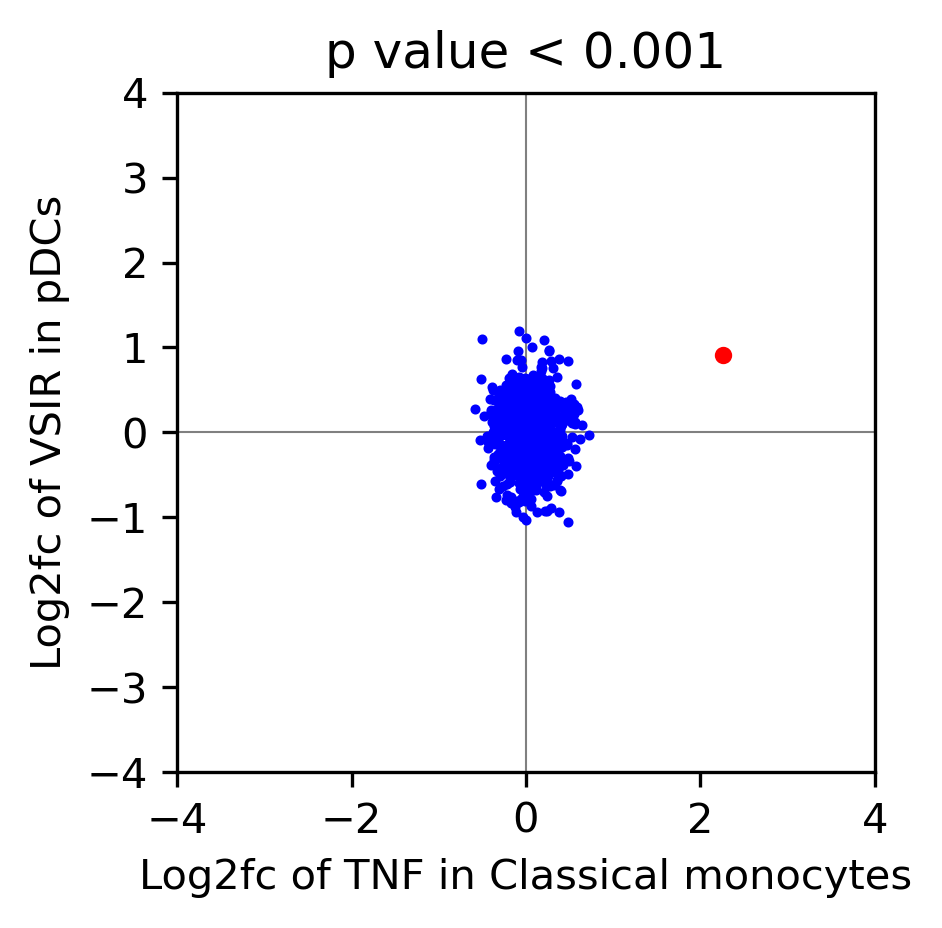

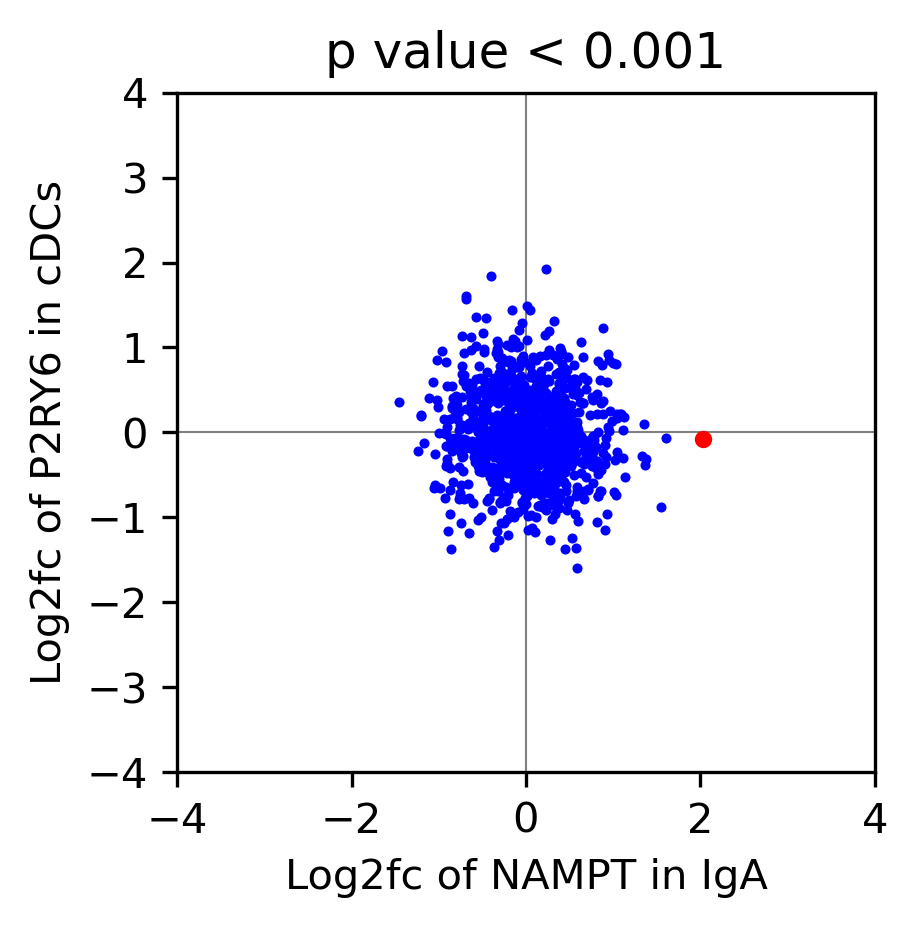

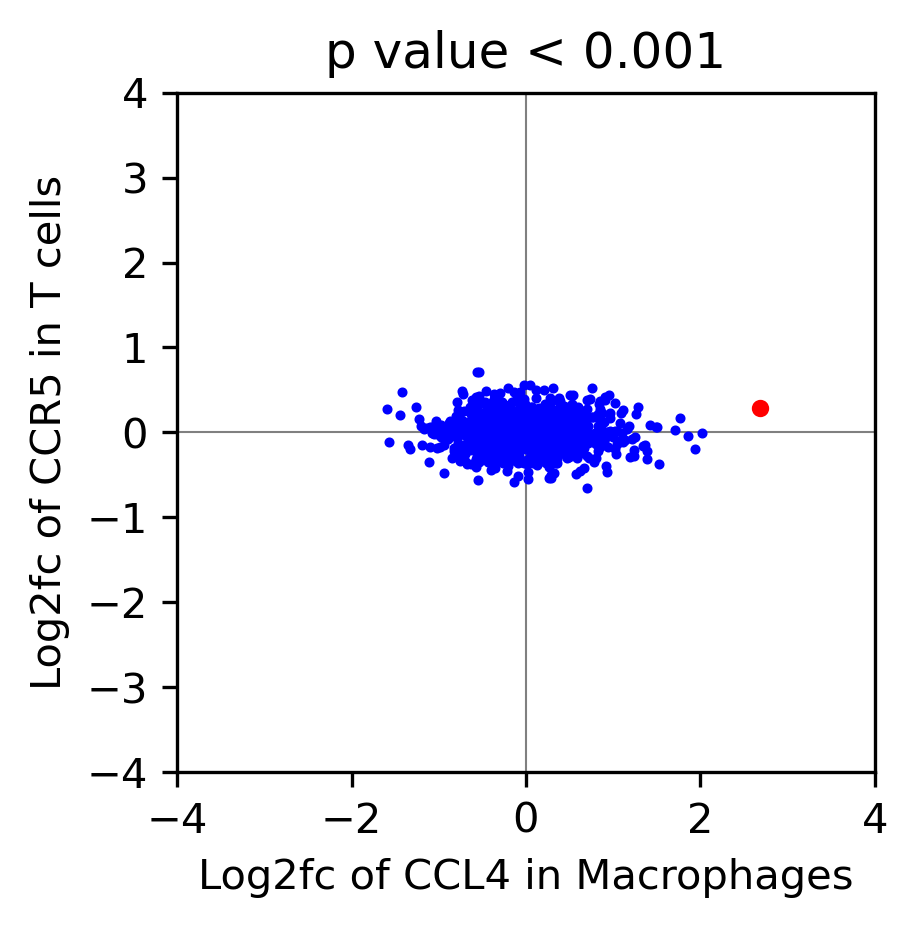

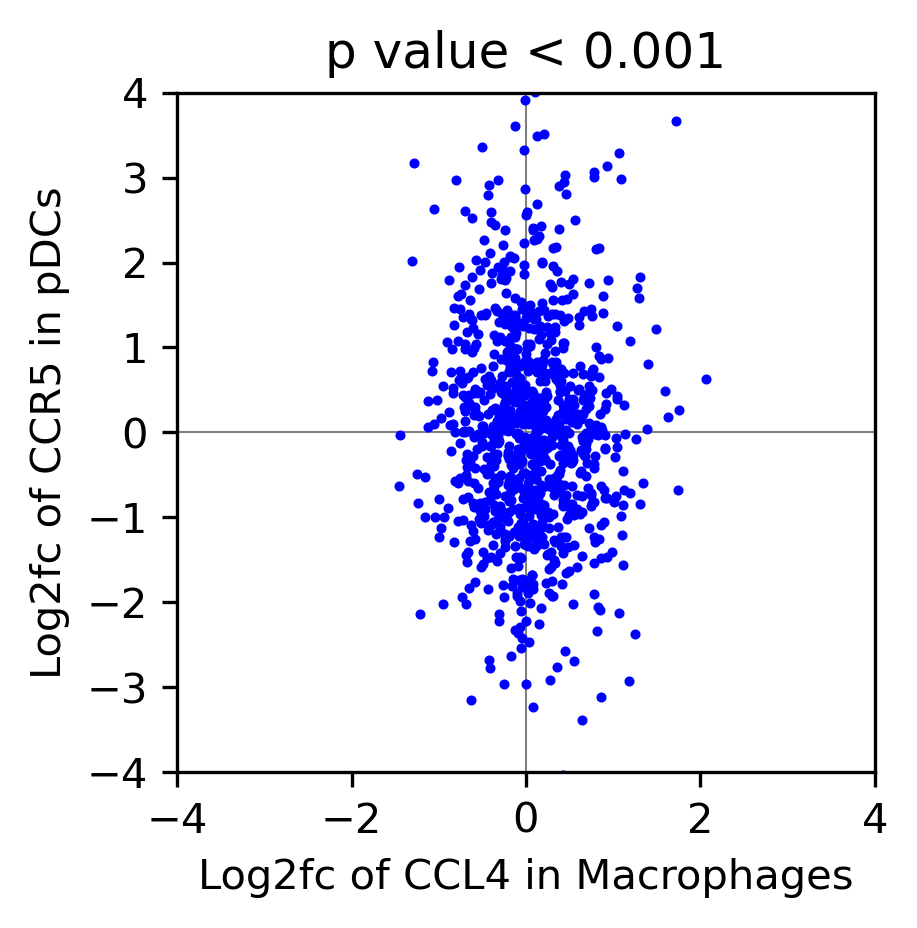

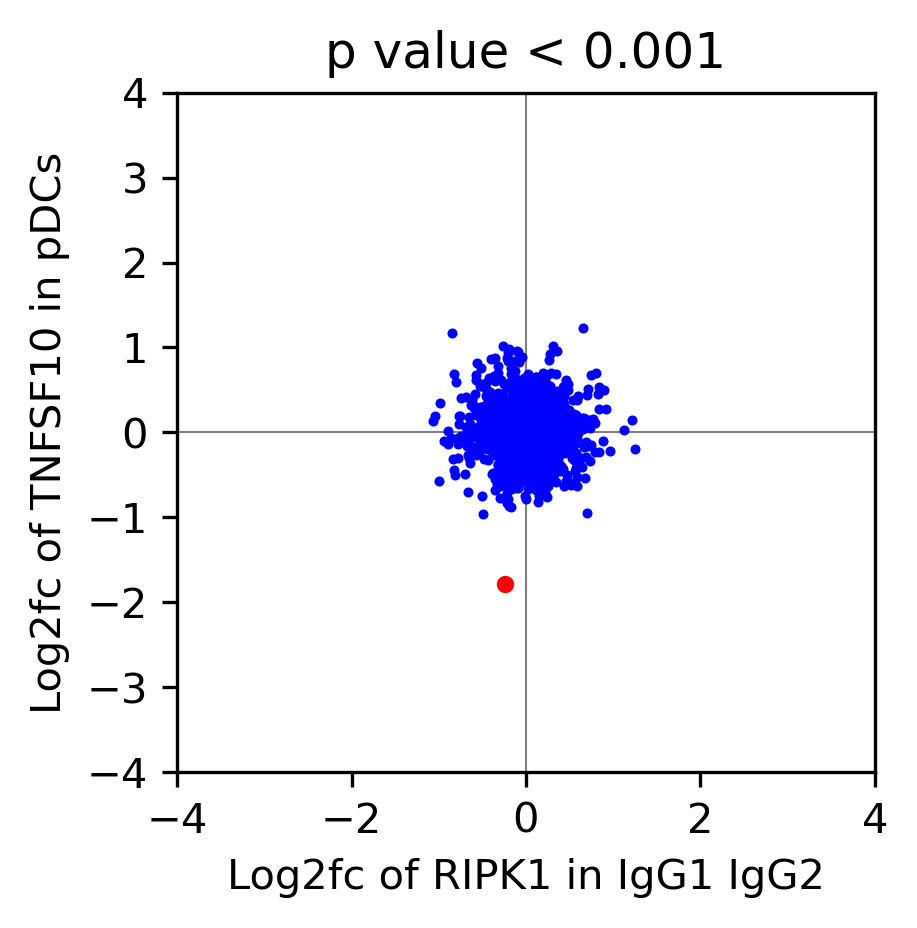

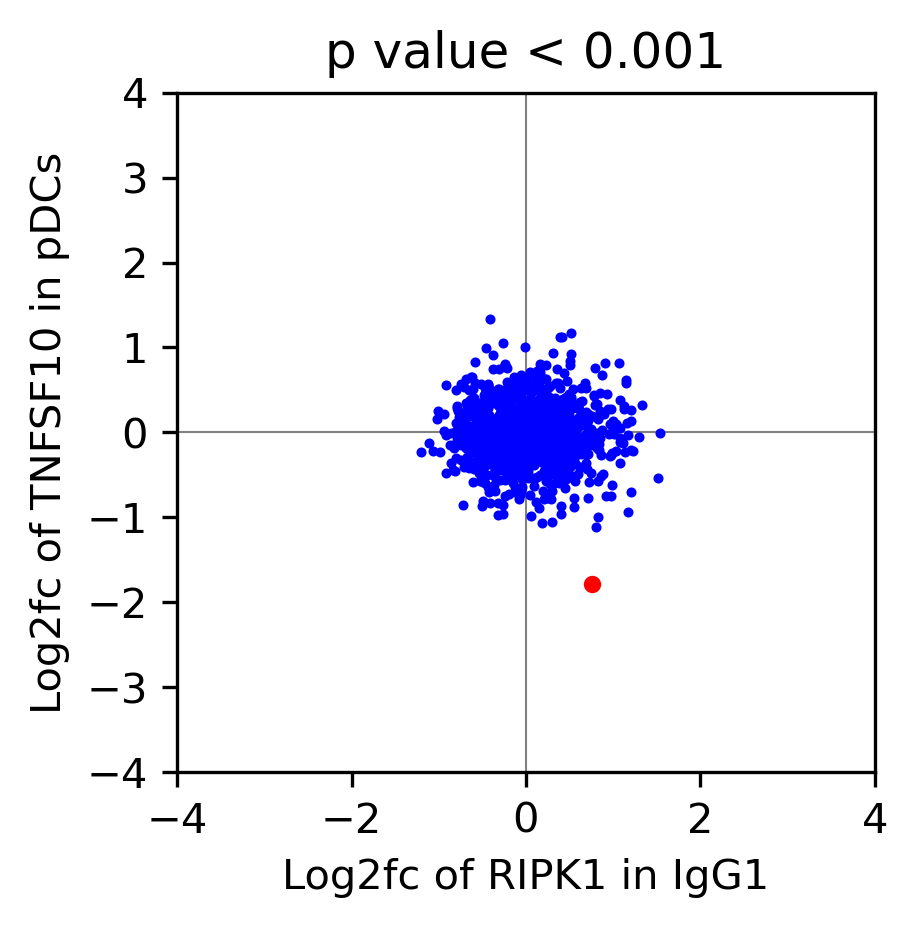

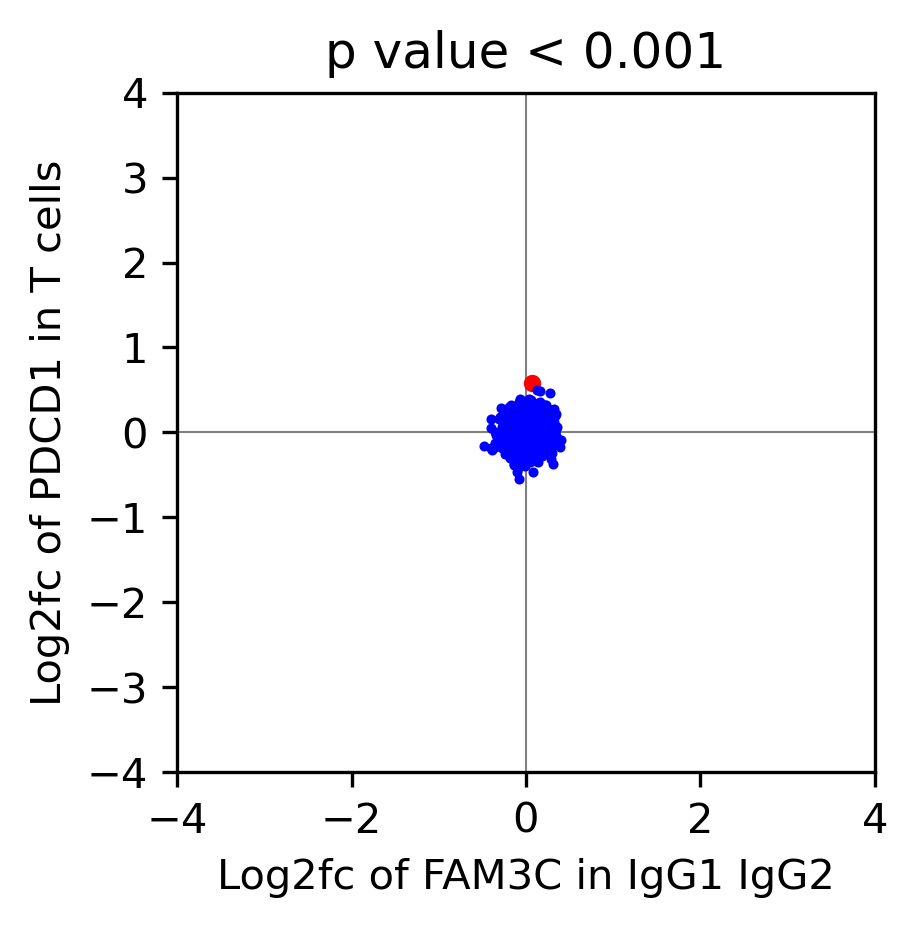

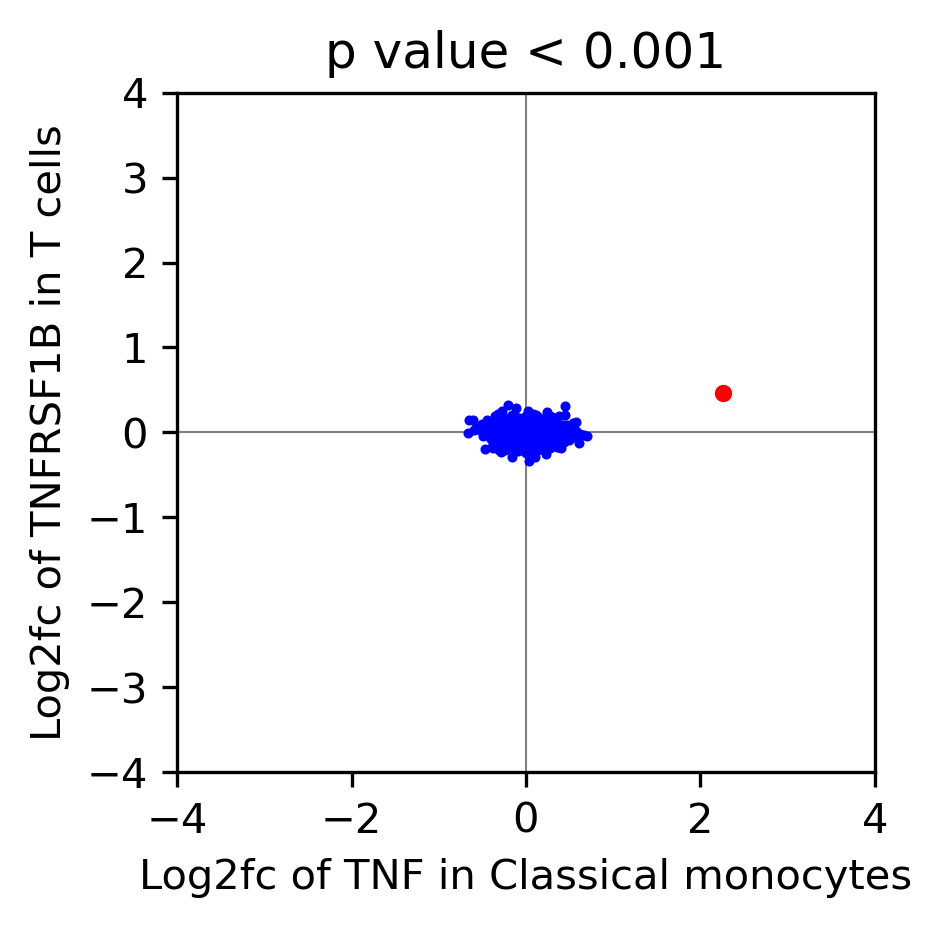

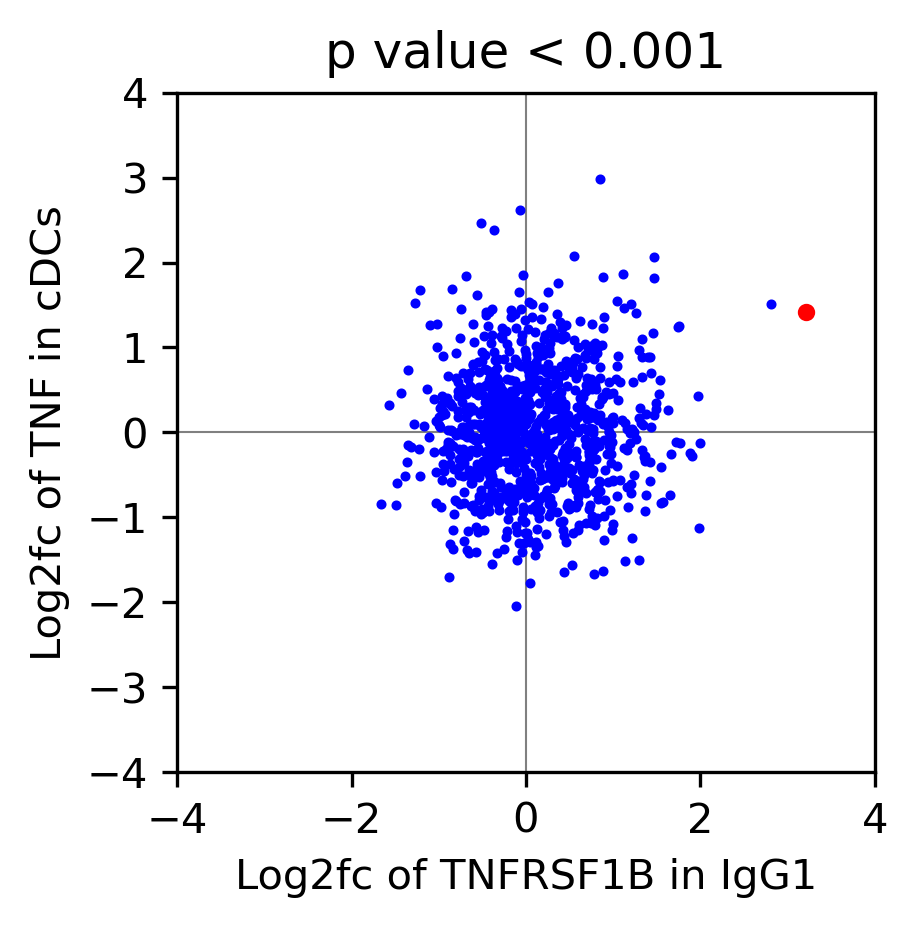

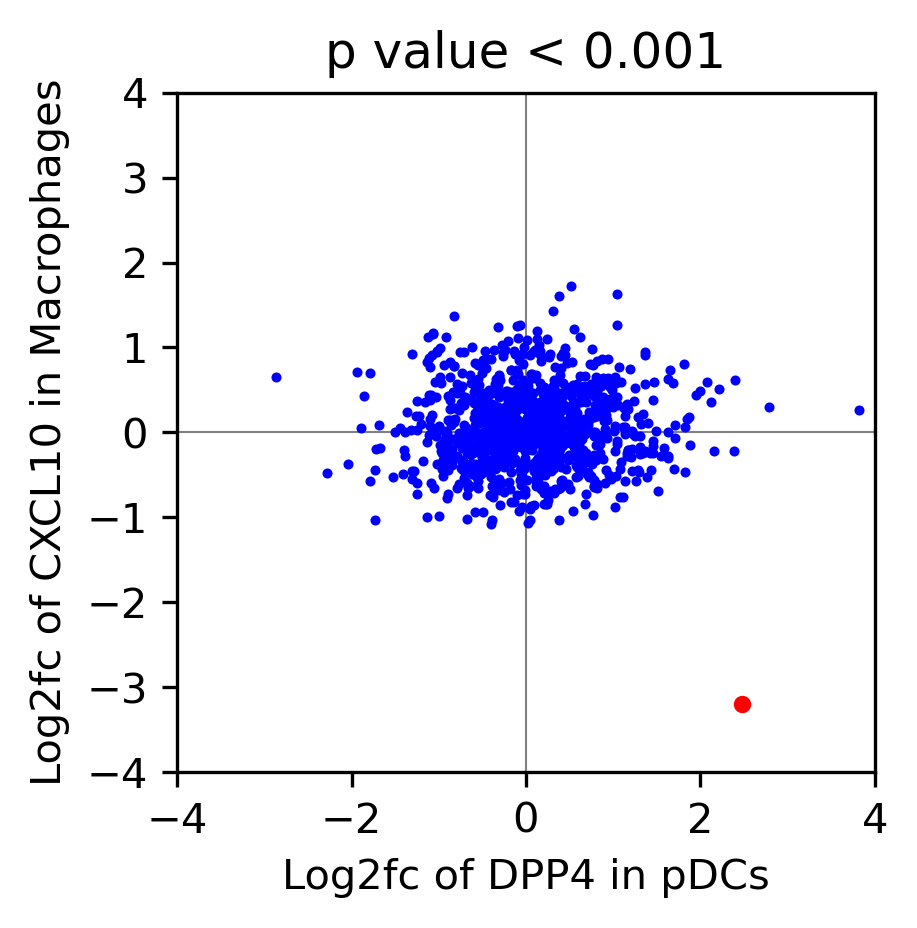

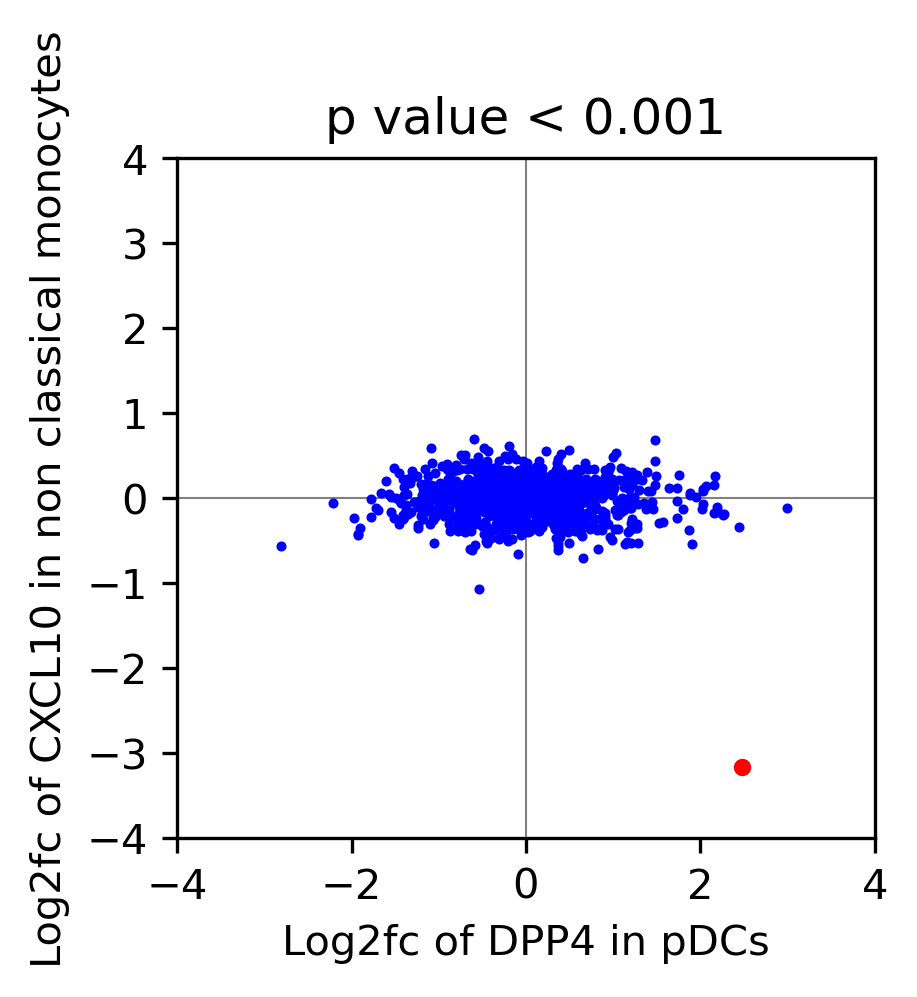

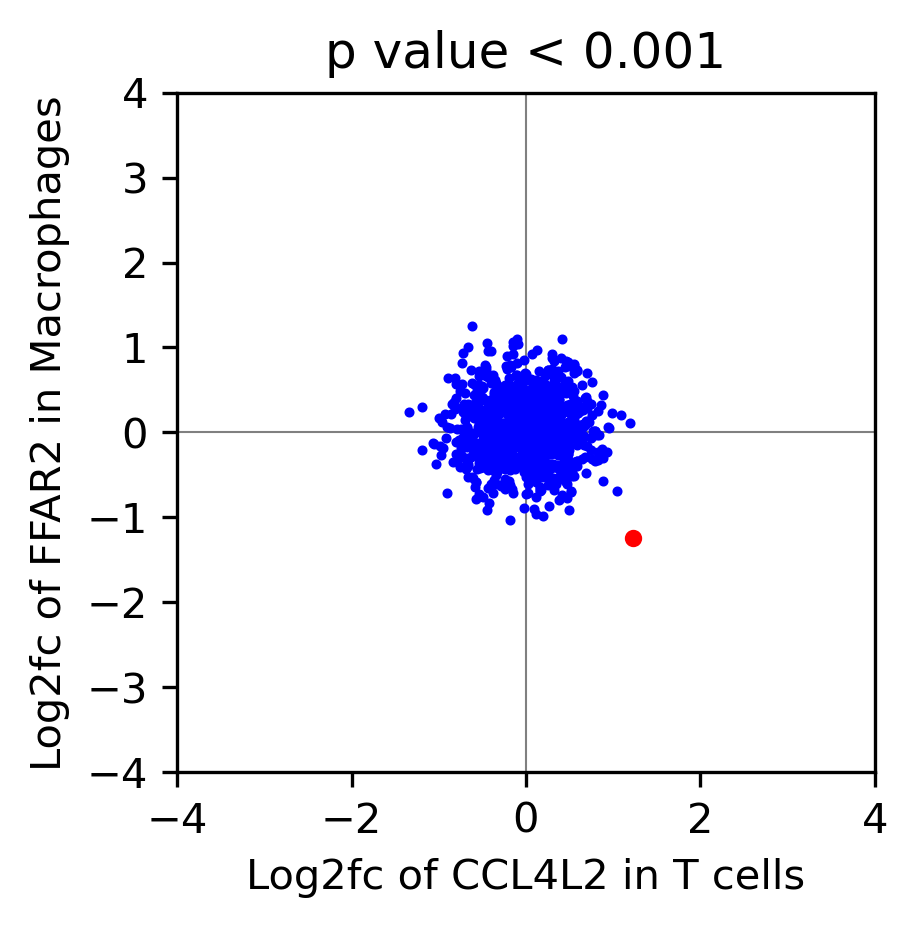

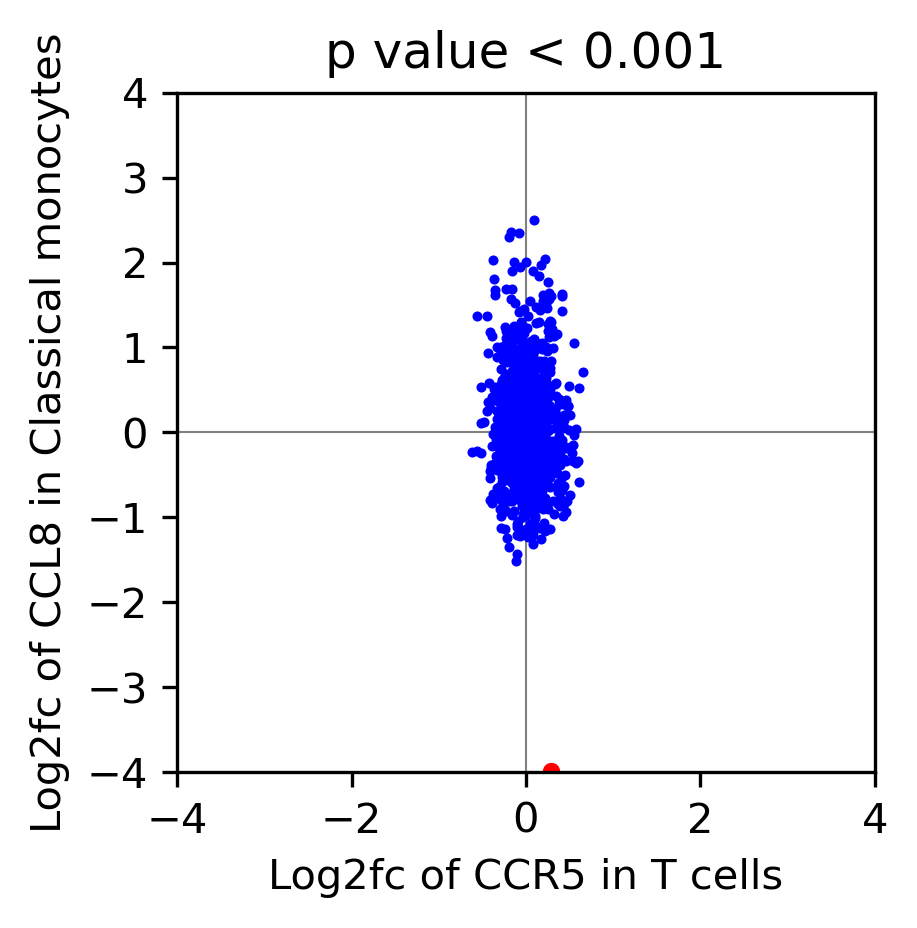

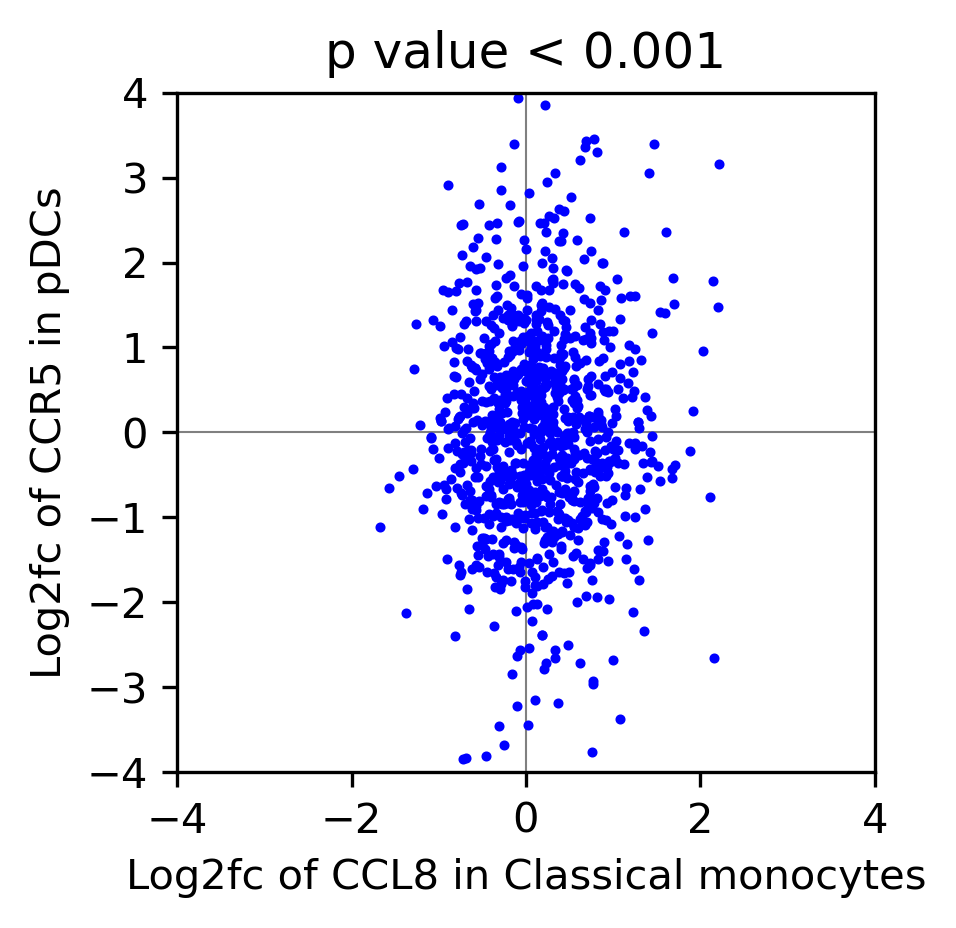

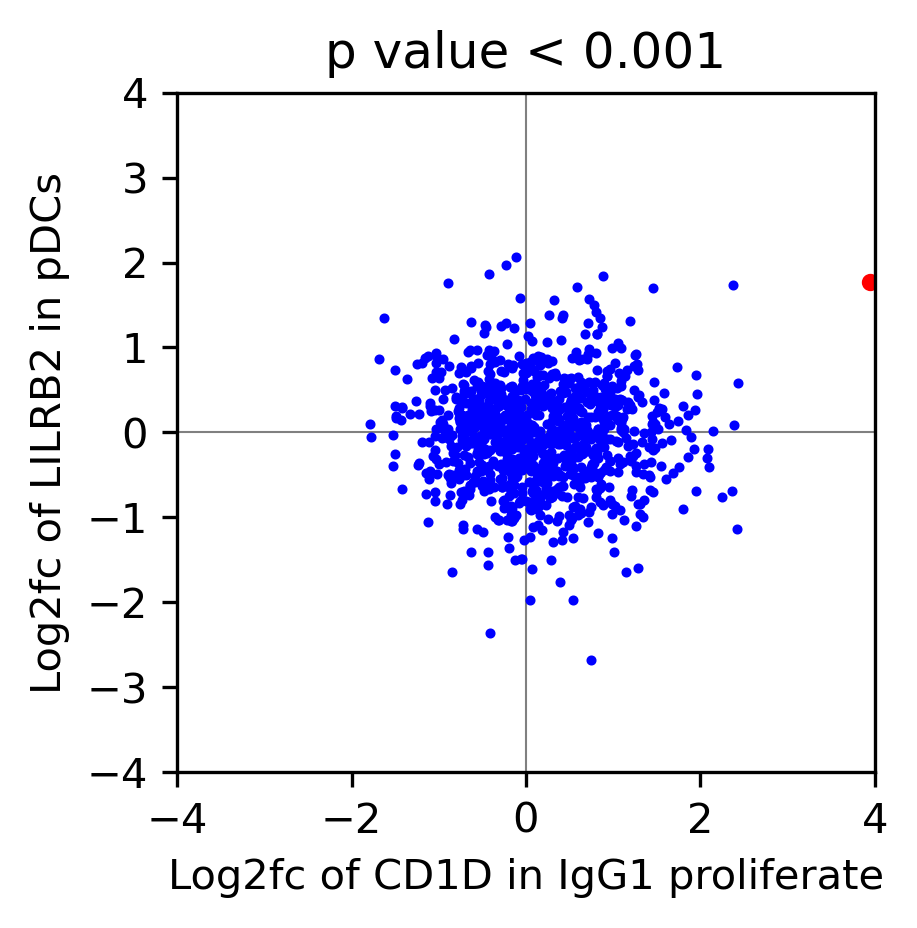

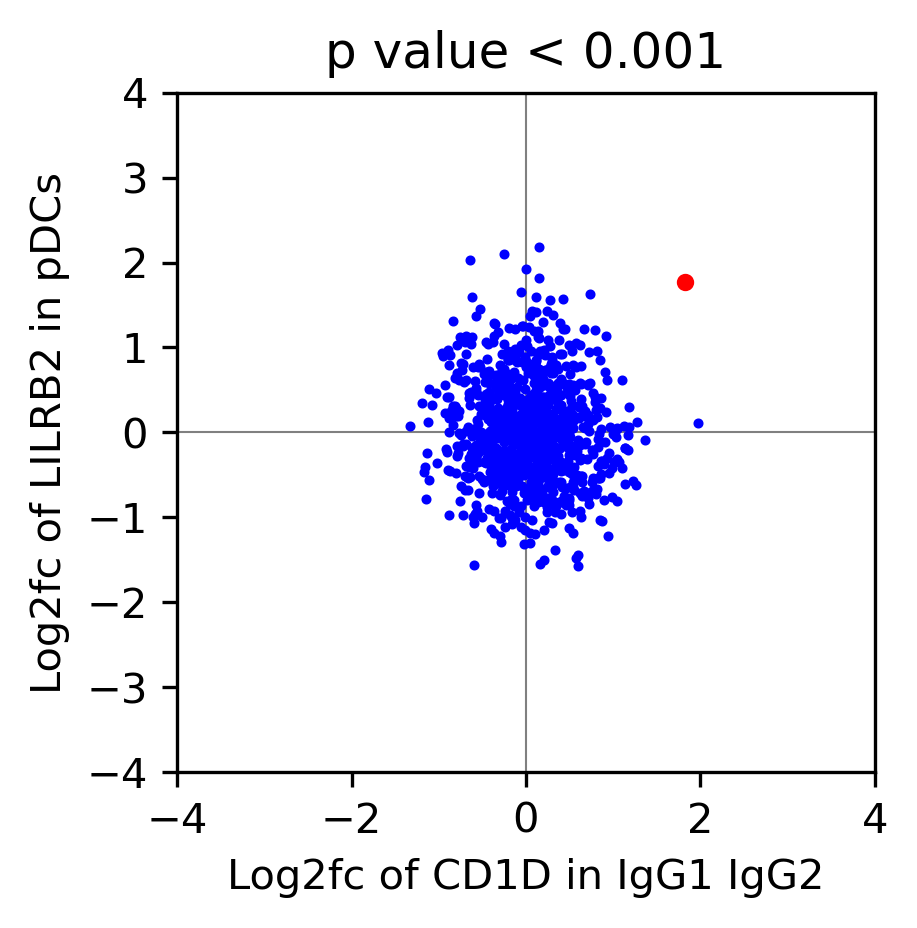

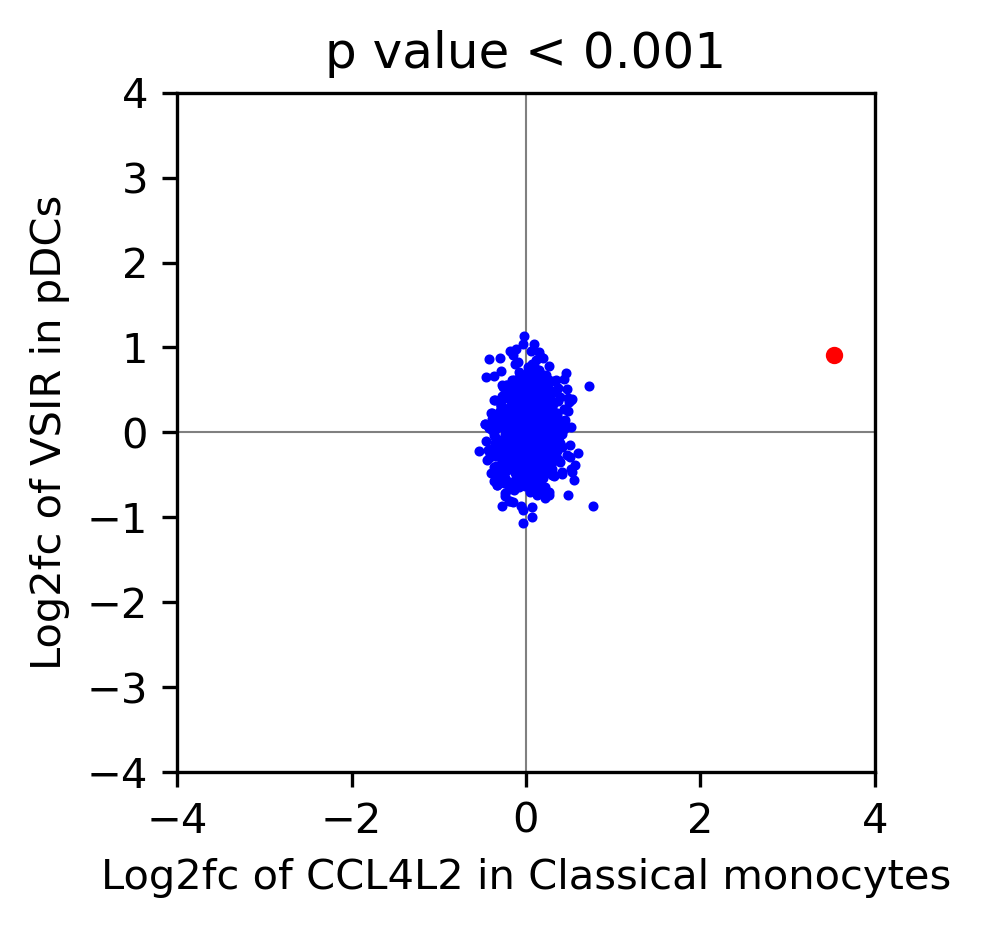

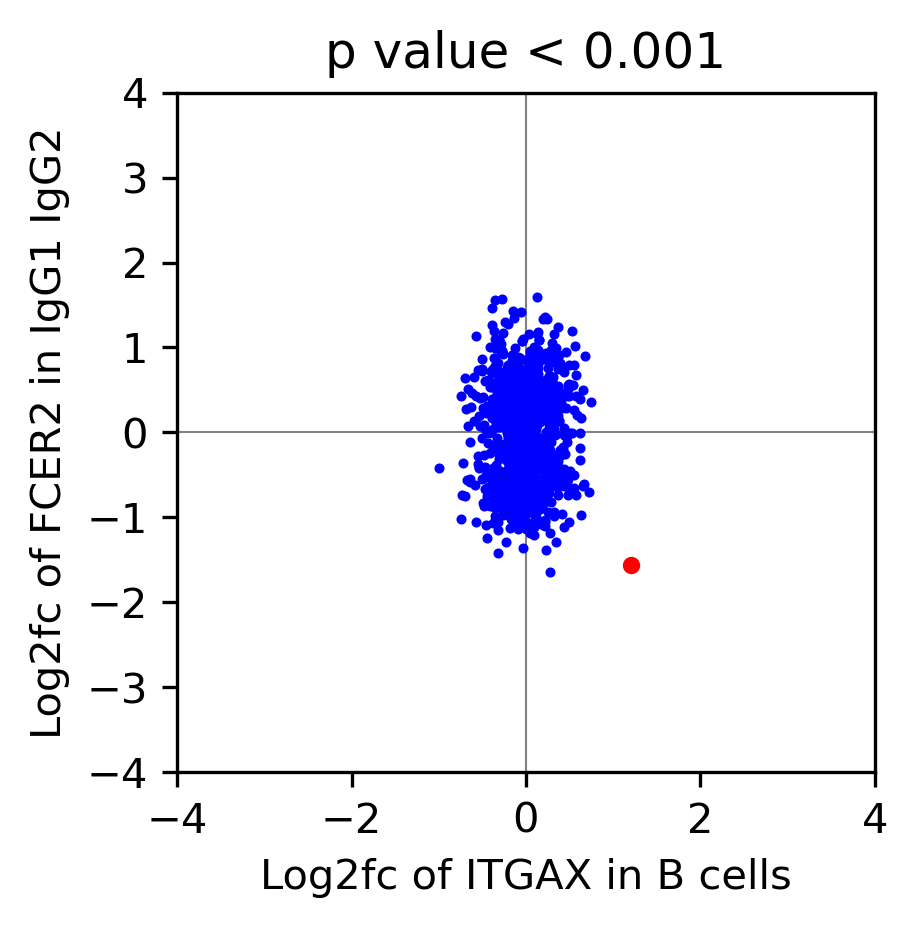

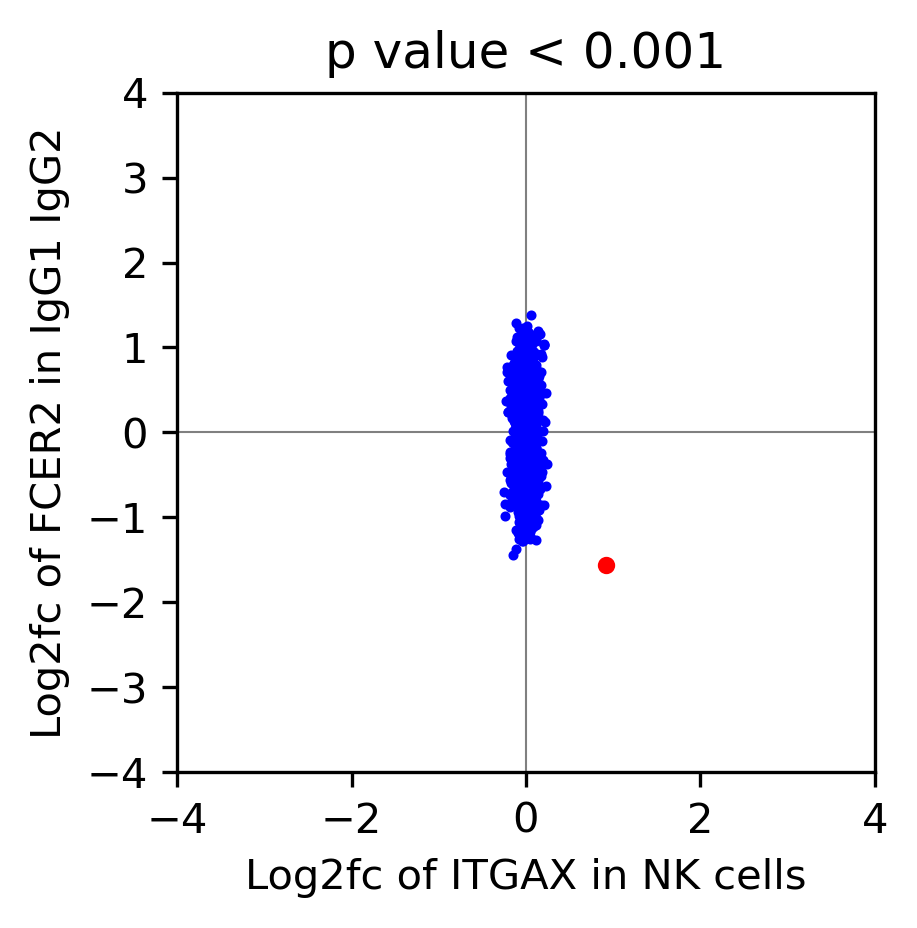

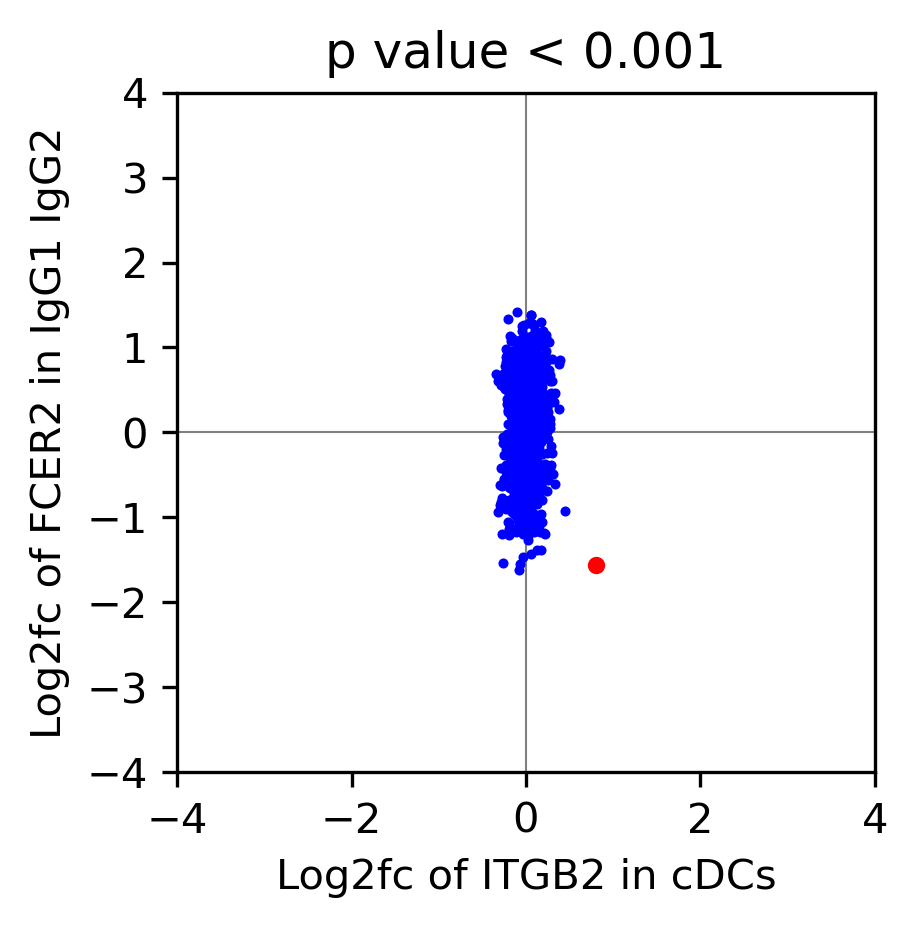

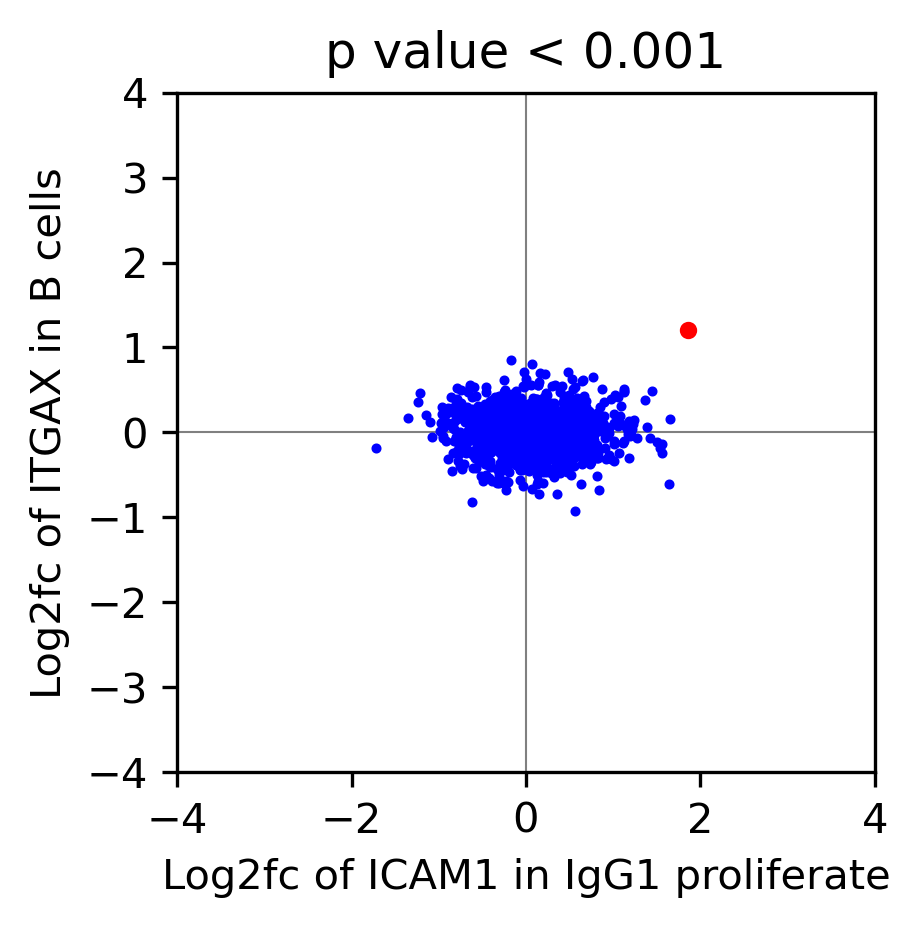

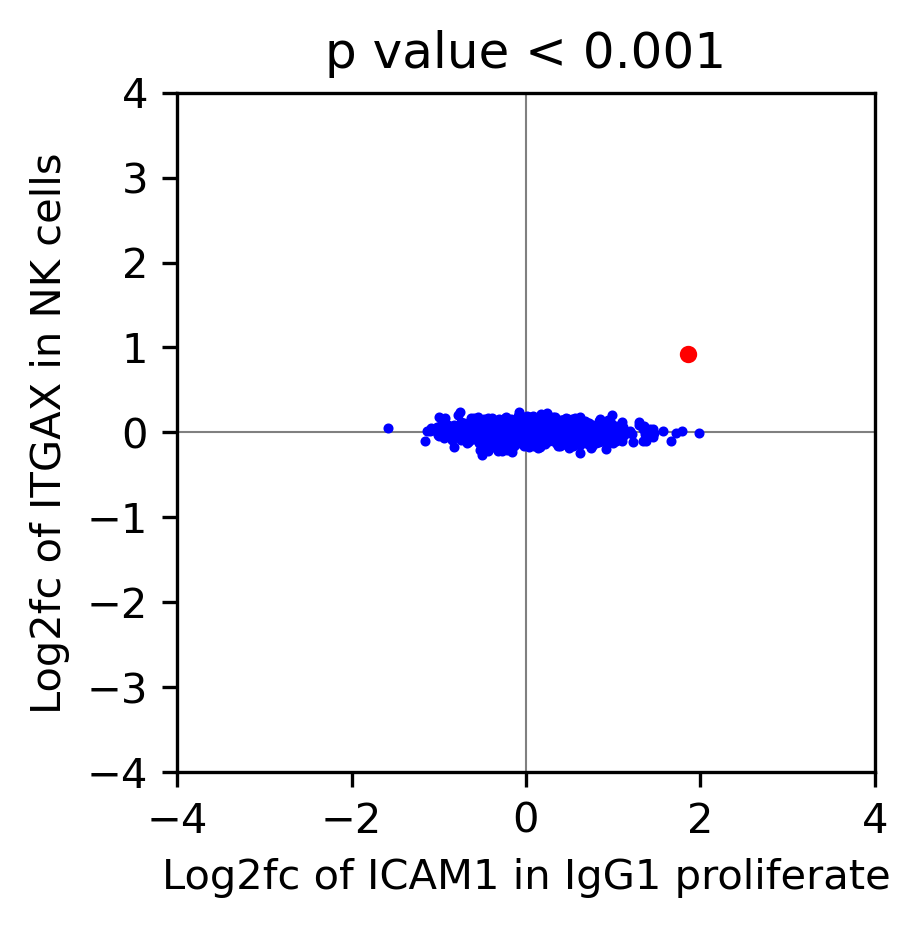

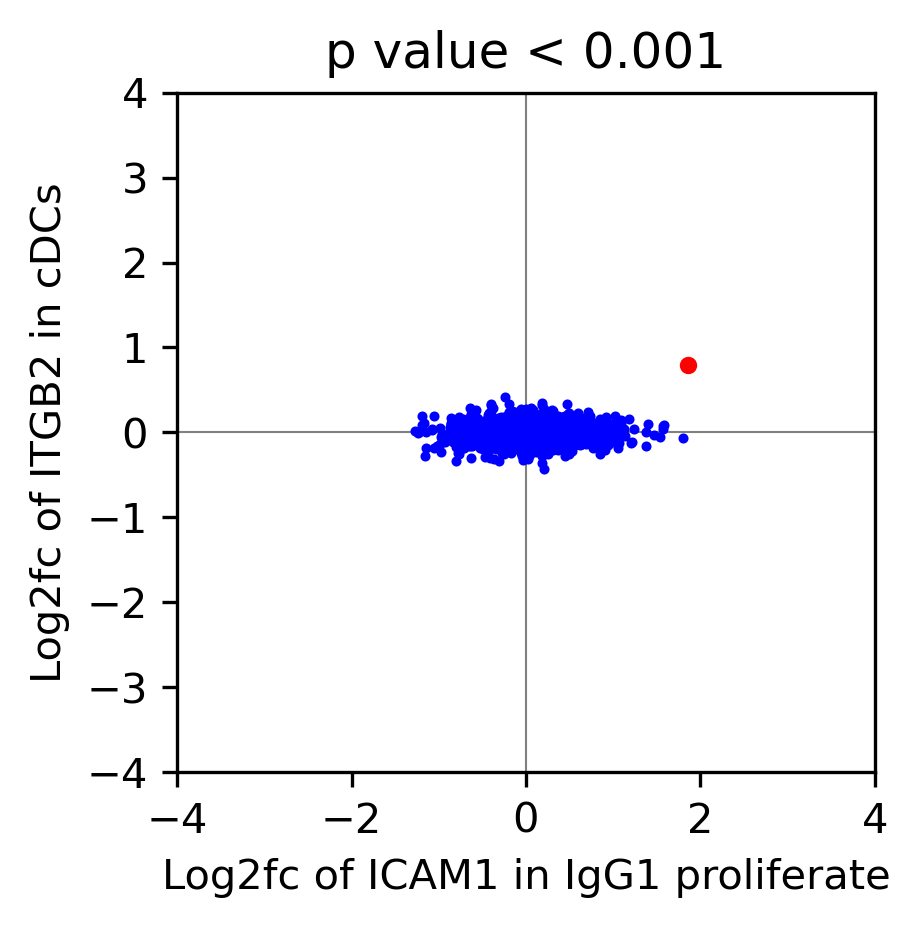

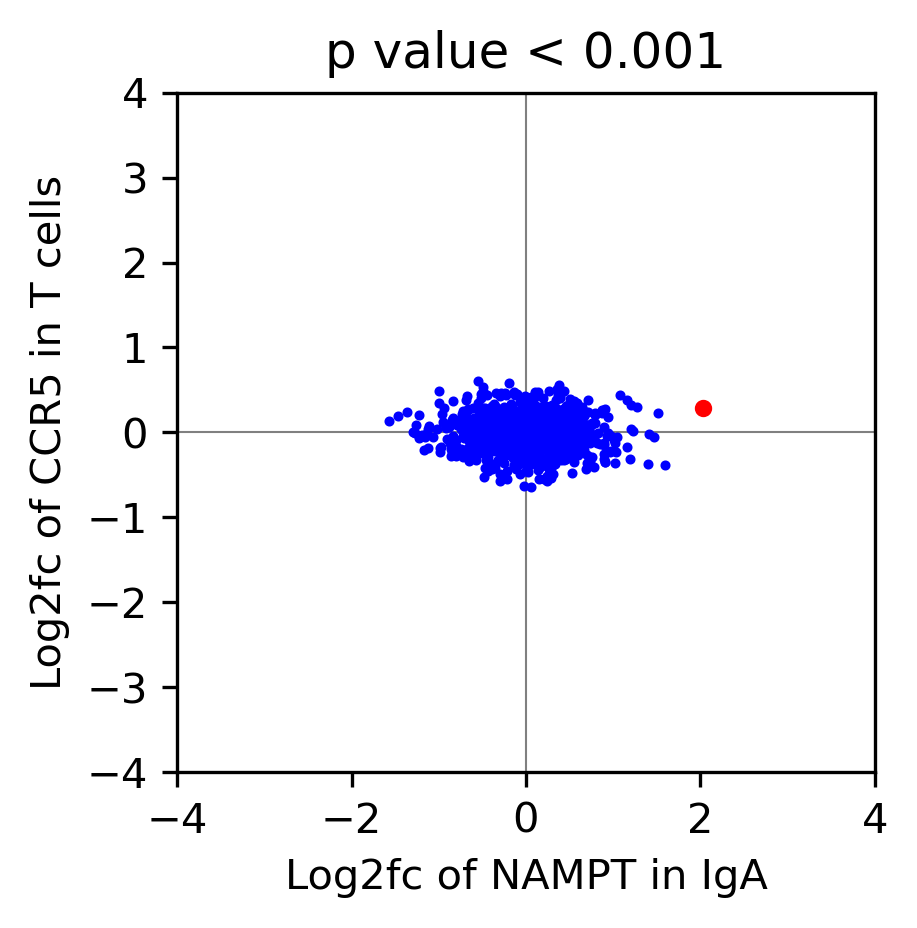

In [170]:
fdn = '/home/yike/phd/dengue/figures/cell_subtype/ran_Mo&Pl_cts/'
randomization_plot(fdn, ran_filter, ran_res)

In [155]:
def s_mushrooms(genes):
    '''
    genes = [{'ITGAX': ['B_cells', 'NK_cells'],
          'ITGB2': ['cDCs'],
          'ICAM1': ['Plasmablasts']},
         {'CCL4L2': ['Monocytes'], 'VSIR': ['pDCs']}]
    '''
    from matplotlib.patches import Wedge
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math
    import numpy as np
    import pandas as pd
    import itertools

    conditions = ['S_dengue', 'dengue']
    cmap = plt.cm.get_cmap('viridis')
    vmin, vmax = -1, 3
    threshold = 0.01
    frac_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/fra.tsv', 
                      sep='\t', index_col=['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    avg_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/avg.tsv', sep='\t',
                      index_col=['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    
    frac_ct = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/fra.tsv', 
                          index_col=['cell_type', 'condition', 'gene'], squeeze=True)
    avg_ct = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/exp.tsv', 
                         index_col=['cell_type', 'condition', 'gene'], squeeze=True)

    yl = sum([len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes])
    fig = plt.figure(figsize=((1 + 0.8 * 2) * 0.6, (1 + yl)* 0.6), dpi=300)

    grid = plt.GridSpec(yl , 2, wspace=0.1, hspace=0.1)
    
    cell_types = ['B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs']
    cell_subtypes = ['Macrophages', 
            'non_classical_monocytes',
            'IgA',
            'IgG1_proliferate',
            'Classical_monocytes',
            'IgG1_IgG2',
            'IgG1',
            'IgM',]

    axs = []
    for i in range(len(genes)):
         axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
    size_bar = plt.subplot(grid[0: 5, 1: 2])

    datap = []
    for genesi, ax in zip(genes, axs):
        cts = list(genesi.values())
        gs = list(genesi.keys())
        yticklabels = []
        for i, (csts, gene) in enumerate(zip(cts, gs)):
            avgs = []
            for cst in csts:
                yticklabels.append(gene + ' in\n' + cst.replace('_', ' '))
                for k, cond in enumerate(conditions):
                    if cst in cell_types:
                        fr = frac_ct.loc[(cst, cond, gene)]
                        av = np.log10(avg_ct.loc[(cst, cond, gene)] + 0.1)
                    elif cst in cell_subtypes:
                        fr = frac_cst.loc[(cst, cond, gene)]
                        av = np.log10(avg_cst.loc[(cst, cond, gene)] + 0.1)
                    avgs.append(av)

                    r = 0.5 * fr**0.3
                    color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                    theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                    datap.append({
                        'r': r,
                        'facecolor': color,
                        'center': (0, len(yticklabels)-1),
                        'theta': (theta0, theta1),
                        'ax': ax,
                    })
                if avgs[0] - avgs[1] > threshold:
                    datap[-2]['edgecolor'] = 'red'
                    datap[-1]['edgecolor'] = 'none'
                elif avgs[0] - avgs[1] < -threshold:
                    datap[-1]['edgecolor'] = 'red'
                    datap[-2]['edgecolor'] = 'none'
                else:
                    datap[-1]['edgecolor'] = 'none'
                    datap[-2]['edgecolor'] = 'none'   


        ax.set_yticks(np.arange(len(list(itertools.chain.from_iterable(genesi.values())))))
        ax.set_yticklabels(yticklabels)
        ax.set_ylim(-0.6, len(list(itertools.chain.from_iterable(genesi.values()))) - 0.4)        
        ax.set_xticks([])
        ax.set_xlim(-0.6, 1 - 0.4)

    for datum in datap:
        ax = datum['ax']
        r = datum['r']
        color = datum['facecolor']
        center = datum['center']
        theta0, theta1 = datum['theta']
        ec = datum['edgecolor']

        h = Wedge(
            center, r, theta0, theta1, facecolor=color, edgecolor=ec
        )
        ax.add_artist(h)
        ax.set_aspect(1)

    size_bar.set_ylim(-0.6, 5 - 0.4)        
    c = [(0.5, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        size_bar.add_artist(e)
    size_bar.set_aspect(1)
    size_bar.set_yticks([])
    size_bar.set_yticks(range(5))
    size_bar.set_yticklabels(['5', '10', '20', '40', '80'])
    size_bar.yaxis.tick_right()
    size_bar.yaxis.set_label_position('right')
    size_bar.set_ylabel('Gene exp frac')
    size_bar.set_xticks([])
    size_bar.spines['bottom'].set_visible(False)
    size_bar.spines['top'].set_visible(False)
    size_bar.spines['right'].set_visible(False)
    size_bar.spines['left'].set_visible(False)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.7, 0.2, 0.05, 2/yl])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=position, ax=axs[-1], label='Gene exp \n(log10[cpm+0.1])')

    fig.tight_layout()
    return {'fig': fig, 'ax': axs}

In [115]:
ran_inters = ran_inters.reset_index()
ran_inters.set_index('inter_type', inplace=True)

up_inters = ran_inters.loc['up']
down_inters = ran_inters.loc['down']
mix_inters = ran_inters.loc['mix']
#############################################
def genes_transfer(genes):    
    new_genes = []
    for i, gene in enumerate(genes):
        new_genes.append({})
        for key in gene.keys():
            if isinstance(gene[key], list):
                new_genes[i][key] = gene[key]
            else:
                new_genes[i][key] = [gene[key]]
                
    inters = []
    f_genes = []
    for i, inter in enumerate(new_genes):
        it = list(inter.keys())
        if it not in inters:
            inters.append(it)
            f_genes.append(inter)
        else:
            for j, itj in enumerate(inters):
                if it == itj:
                    if inter[it[0]][0] not in f_genes[j][it[0]]:
                        f_genes[j][it[0]].append(inter[it[0]][0])
                    if inter[it[1]][0] not in f_genes[j][it[1]]:
                        f_genes[j][it[1]].append(inter[it[1]][0])            
    return f_genes
################################################
up_genes = [{ga: csta, gb: cstb} for ga, csta, gb, cstb in zip(up_inters['ga'].tolist(), 
                                                               up_inters['csta'].tolist(), 
                                                               up_inters['gb'].tolist(), 
                                                               up_inters['cstb'].tolist())]
down_genes = [{ga: csta, gb: cstb} for ga, csta, gb, cstb in zip(down_inters['ga'].tolist(), 
                                                                 down_inters['csta'].tolist(), 
                                                                 down_inters['gb'].tolist(), 
                                                                 down_inters['cstb'].tolist())]
mix_genes = [{ga: csta, gb: cstb} for ga, csta, gb, cstb in zip(mix_inters['ga'].tolist(), 
                                                                mix_inters['csta'].tolist(), 
                                                                mix_inters['gb'].tolist(), 
                                                                mix_inters['cstb'].tolist())]
up_genes = genes_transfer(up_genes)
down_genes = genes_transfer(down_genes)
mix_genes = genes_transfer(mix_genes)

mushroom_genes = up_genes + down_genes + mix_genes

###Comments: the expression of P2RY6 in cDCs is not significant in mushroom plot

<ipython-input-155-698399067179>:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x9000 with 24 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

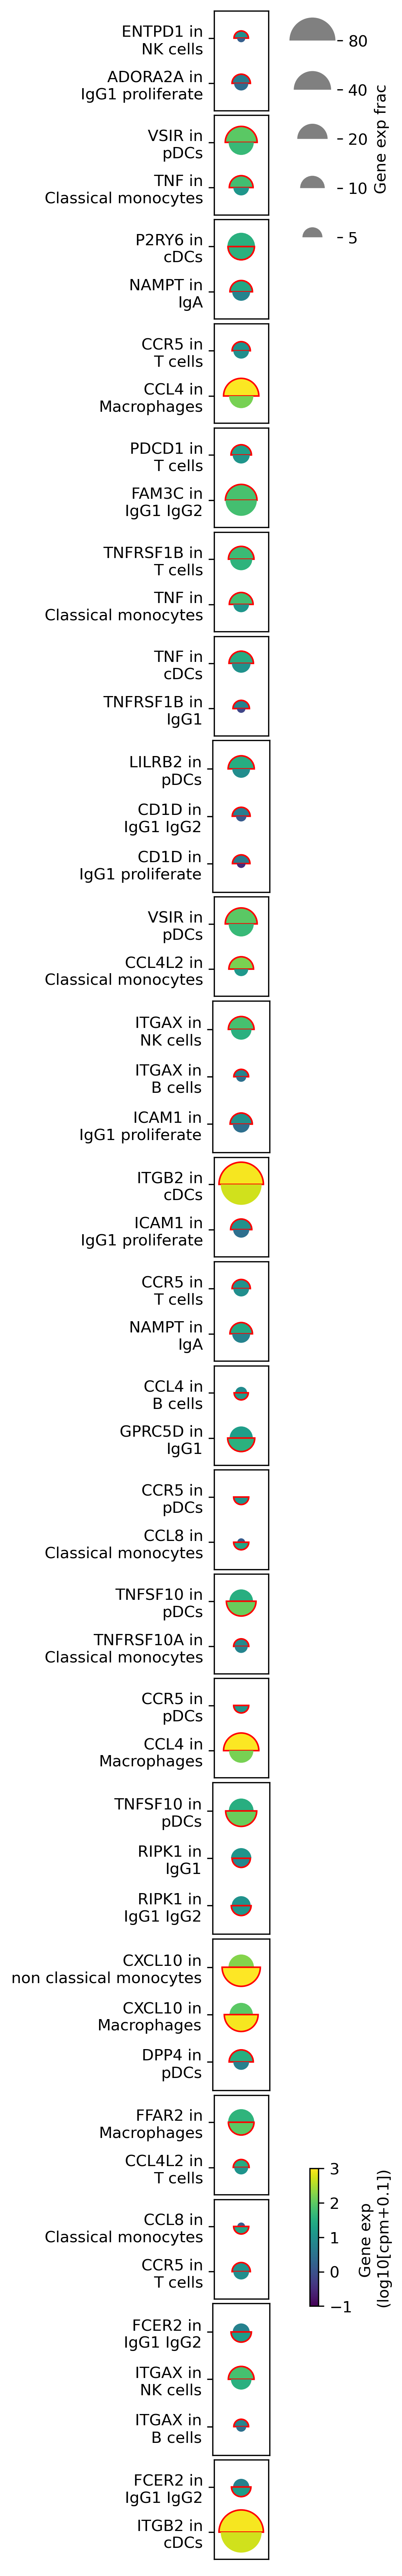

In [156]:
s_mushrooms(mushroom_genes)

In [171]:
up_genes

[{'ADORA2A': ['IgG1_proliferate'], 'ENTPD1': ['NK_cells']},
 {'TNF': ['Classical_monocytes'], 'VSIR': ['pDCs']},
 {'NAMPT': ['IgA'], 'P2RY6': ['cDCs']},
 {'CCL4': ['Macrophages'], 'CCR5': ['T_cells']},
 {'FAM3C': ['IgG1_IgG2'], 'PDCD1': ['T_cells']},
 {'TNF': ['Classical_monocytes'], 'TNFRSF1B': ['T_cells']},
 {'TNFRSF1B': ['IgG1'], 'TNF': ['cDCs']},
 {'CD1D': ['IgG1_proliferate', 'IgG1_IgG2'], 'LILRB2': ['pDCs']},
 {'CCL4L2': ['Classical_monocytes'], 'VSIR': ['pDCs']},
 {'ICAM1': ['IgG1_proliferate'], 'ITGAX': ['B_cells', 'NK_cells']},
 {'ICAM1': ['IgG1_proliferate'], 'ITGB2': ['cDCs']},
 {'NAMPT': ['IgA'], 'CCR5': ['T_cells']}]

In [172]:
down_genes

[{'GPRC5D': ['IgG1'], 'CCL4': ['B_cells']},
 {'CCL8': ['Classical_monocytes'], 'CCR5': ['pDCs']}]

In [173]:
mix_genes

[{'TNFRSF10A': ['Classical_monocytes'], 'TNFSF10': ['pDCs']},
 {'CCL4': ['Macrophages'], 'CCR5': ['pDCs']},
 {'RIPK1': ['IgG1_IgG2', 'IgG1'], 'TNFSF10': ['pDCs']},
 {'DPP4': ['pDCs'], 'CXCL10': ['Macrophages', 'non_classical_monocytes']},
 {'CCL4L2': ['T_cells'], 'FFAR2': ['Macrophages']},
 {'CCR5': ['T_cells'], 'CCL8': ['Classical_monocytes']},
 {'ITGAX': ['B_cells', 'NK_cells'], 'FCER2': ['IgG1_IgG2']},
 {'ITGB2': ['cDCs'], 'FCER2': ['IgG1_IgG2']}]

In [4]:
ran_inters = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/pair_filter_inters_Mo&Pl_cst.tsv', 
                         sep='\t')
up_inters = ran_inters[ran_inters['inter_type'] == 'up']
down_inters = ran_inters[ran_inters['inter_type'] == 'down']
mix_inters = ran_inters[ran_inters['inter_type'] == 'mix']

up_g = [(ga, csta, gb, cstb) for ga, csta, gb, cstb in zip(up_inters['ga'].tolist(), 
                                                               up_inters['csta'].tolist(), 
                                                               up_inters['gb'].tolist(), 
                                                               up_inters['cstb'].tolist())]
down_g = [(ga, csta, gb, cstb) for ga, csta, gb, cstb in zip(down_inters['ga'].tolist(), 
                                                                 down_inters['csta'].tolist(), 
                                                                 down_inters['gb'].tolist(), 
                                                                 down_inters['cstb'].tolist())]
mix_g = [(ga, csta, gb, cstb) for ga, csta, gb, cstb in zip(mix_inters['ga'].tolist(), 
                                                                mix_inters['csta'].tolist(), 
                                                                mix_inters['gb'].tolist(), 
                                                                mix_inters['cstb'].tolist())]
csts_inters = up_g + down_g + mix_g

cts_inters = [('ITGAX', 'B_cells', 'ICAM1', 'Plasmablasts'),
             ('ENTPD1', 'NK_cells', 'ADORA2A', 'Plasmablasts'),
             ('ITGAX', 'NK_cells', 'ICAM1', 'Plasmablasts'),
             ('ICAM1', 'Plasmablasts', 'ITGB2', 'cDCs'),
             ('CTLA4', 'T_cells', 'CD86', 'T_cells'),
             ('IL6', 'Monocytes', 'IL6ST', 'Plasmablasts'),
             ('CCL4L2', 'T_cells', 'VSIR', 'pDCs'),
             ('CCL4L2', 'Monocytes', 'VSIR', 'pDCs'),
             ('KLRF1', 'Monocytes', 'CLEC2B', 'Plasmablasts'),
             ('CXCR2', 'Monocytes', 'PPBP', 'Plasmablasts'),
             ('CLEC2B', 'Plasmablasts', 'KLRF1', 'Plasmablasts'),
             ('LTBR', 'cDCs', 'LTB', 'Plasmablasts'),
             ('CXCR3', 'Plasmablasts', 'CXCL10', 'Monocytes'),
             ('CCR2', 'Plasmablasts', 'CCL2', 'Monocytes'),
             ('CCR5', 'T_cells', 'CCL4', 'B_cells'),
             ('RETN', 'Monocytes', 'GPR25', 'Plasmablasts'),
             ('DPP4', 'pDCs', 'CXCL10', 'Monocytes'),
             ('SLC1A5', 'T_cells', 'LGALS9', 'Plasmablasts'),
             ('CCL4L2', 'Monocytes', 'FFAR2', 'Monocytes'),
             ('CCL4L2', 'T_cells', 'FFAR2', 'Monocytes'),
             ('BAG6', 'cDCs', 'NCR3', 'Plasmablasts'),
             ('CXCL8', 'Monocytes', 'CXCR2', 'Monocytes'),
             ('CCR2', 'Plasmablasts', 'CCL8', 'Monocytes'),
             ('CCR5', 'T_cells', 'CCL8', 'Monocytes'),
             ('HAVCR2', 'T_cells', 'LGALS9', 'Plasmablasts'),
             ('ITGAX', 'B_cells', 'FCER2', 'Plasmablasts'),
             ('ITGAX', 'NK_cells', 'FCER2', 'Plasmablasts'),
             ('ITGB2', 'cDCs', 'FCER2', 'Plasmablasts')]

In [5]:
cts_its = [(inter[0], inter[2]) for inter in cts_inters]
csts_its = [(inter[0], inter[2]) for inter in csts_inters]

csts_in = [inter for inter in csts_inters if ((inter[0], inter[2]) in cts_its) | ((inter[2], inter[0]) in cts_its)]
csts_out = [inter for inter in csts_inters if ((inter[0], inter[2]) not in cts_its) & ((inter[2], inter[0]) not in cts_its)]

In [7]:
ran_inters.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)

In [13]:
in_inters = ran_inters.loc[csts_in]
in_inters.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/Mo&Pl_cst_inters_in_cst.tsv', sep='\t')
in_inters

ga_med_pair  \
ga      csta                gb     cstb                                   
ADORA2A IgG1_proliferate    ENTPD1 NK_cells                    1.466633   
CCL4    Macrophages         CCR5   T_cells                     1.021308   
CCL4L2  Classical_monocytes VSIR   pDCs                        1.235812   
ICAM1   IgG1_proliferate    ITGAX  B_cells                     2.342427   
                                   NK_cells                    2.342427   
                            ITGB2  cDCs                        2.342427   
CCL8    Classical_monocytes CCR5   pDCs                       -4.680548   
CCL4    Macrophages         CCR5   pDCs                        1.021308   
DPP4    pDCs                CXCL10 Macrophages                 2.703851   
                                   non_classical_monocytes     2.703851   
CCL4L2  T_cells             FFAR2  Macrophages                 1.399274   
CCR5    T_cells             CCL8   Classical_monocytes         1.468848   
ITGAX   B_cells             FCER2  IgG1_IgG2                   1.176716   
        NK_cells            FCER2  IgG1_IgG2                   1.029201   
ITGB2   cDCs                FCER2  IgG1_IgG2                   1.051861   

                                                            ga_fra_pair  \
ga      csta                gb     cstb                                   
ADORA2A IgG1_proliferate    ENTPD1 NK_cells                    0.718750   
CCL4    Macrophages         CCR5   T_cells                     0.607143   
CCL4L2  Classical_monocytes VSIR   pDCs                        0.593750   
ICAM1   IgG1_proliferate    ITGAX  B_cells                     0.937500   
                                   NK_cells                    0.937500   
                            ITGB2  cDCs                        0.937500   
CCL8    Classical_monocytes CCR5   pDCs                        0.062500   
CCL4    Macrophages         CCR5   pDCs                        0.607143   
DPP4    pDCs                CXCL10 Macrophages                 0.843750   
                                   non_classical_monocytes     0.843750   
CCL4L2  T_cells             FFAR2  Macrophages                 0.718750   
CCR5    T_cells             CCL8   Classical_monocytes         0.750000   
ITGAX   B_cells             FCER2  IgG1_IgG2                   0.750000   
        NK_cells            FCER2  IgG1_IgG2                   0.906250   
ITGB2   cDCs                FCER2  IgG1_IgG2                   0.916667   

                                                            ga_SD_fra  \
ga      csta                gb     cstb                                 
ADORA2A IgG1_proliferate    ENTPD1 NK_cells                  0.049967   
CCL4    Macrophages         CCR5   T_cells                   0.436508   
CCL4L2  Classical_monocytes VSIR   pDCs                      0.133143   
ICAM1   IgG1_proliferate    ITGAX  B_cells                   0.080410   
                                   NK_cells                  0.080410   
                            ITGB2  cDCs                      0.080410   
CCL8    Classical_monocytes CCR5   pDCs                      0.002861   
CCL4    Macrophages         CCR5   pDCs                      0.436508   
DPP4    pDCs                CXCL10 Macrophages               0.105991   
                                   non_classical_monocytes   0.105991   
CCL4L2  T_cells             FFAR2  Macrophages               0.030520   
CCR5    T_cells             CCL8   Classical_monocytes       0.048619   
ITGAX   B_cells             FCER2  IgG1_IgG2                 0.020694   
        NK_cells            FCER2  IgG1_IgG2                 0.131067   
ITGB2   cDCs                FCER2  IgG1_IgG2                 0.944206   

                                                            ga_D_fra  \
ga      csta                gb     cstb                                
ADORA2A IgG1_proliferate    ENTPD1 NK_cells                 0.021352   
CCL4    Macrophages         CCR5   T_cells        

In [15]:
out_inters = ran_inters.loc[csts_out]
out_inters.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/Mo&Pl_cst_inters_out_cst', sep='\t')
out_inters

ga_med_pair  ga_fra_pair  \
ga        csta                gb       cstb                                
TNF       Classical_monocytes VSIR     pDCs        1.115522     0.687500   
NAMPT     IgA                 P2RY6    cDCs        2.541867     0.968750   
FAM3C     IgG1_IgG2           PDCD1    T_cells     1.674706     0.821429   
TNF       Classical_monocytes TNFRSF1B T_cells     1.115522     0.687500   
TNFRSF1B  IgG1                TNF      cDCs        3.455887     0.857143   
CD1D      IgG1_proliferate    LILRB2   pDCs        4.236427     1.000000   
          IgG1_IgG2           LILRB2   pDCs        1.558004     0.571429   
NAMPT     IgA                 CCR5     T_cells     2.541867     0.968750   
GPRC5D    IgG1                CCL4     B_cells    -1.149782     0.214286   
TNFRSF10A Classical_monocytes TNFSF10  pDCs        1.394440     0.750000   
RIPK1     IgG1_IgG2           TNFSF10  pDCs        2.730729     0.785714   
          IgG1                TNFSF10  pDCs        1.995224     0.642857   

                                                ga_SD_fra  ga_D_fra  \
ga        csta                gb       cstb                           
TNF       Classical_monocytes VSIR     pDCs      0.117657  0.029512   
NAMPT     IgA                 P2RY6    cDCs      0.098501  0.046683   
FAM3C     IgG1_IgG2           PDCD1    T_cells   0.302400  0.294181   
TNF       Classical_monocytes TNFRSF1B T_cells   0.117657  0.029512   
TNFRSF1B  IgG1                TNF      cDCs      0.034590  0.003839   
CD1D      IgG1_proliferate    LILRB2   pDCs      0.036400  0.003559   
          IgG1_IgG2           LILRB2   pDCs      0.039200  0.006466   
NAMPT     IgA                 CCR5     T_cells   0.098501  0.046683   
GPRC5D    IgG1                CCL4     B_cells   0.108204  0.182342   
TNFRSF10A Classical_monocytes TNFSF10  pDCs      0.026258  0.015891   
RIPK1     IgG1_IgG2           TNFSF10  pDCs      0.047200  0.054957   
          IgG1                TNFSF10  pDCs      0.059867  0.042226   

                                                gb_med_pair  gb_fra_pair  \
ga        csta                gb       cstb                                
TNF       Classical_monocytes VSIR     pDCs        1.549537     0.875000   
NAMPT     IgA                 P2RY6    cDCs        1.093055     0.791667   
FAM3C     IgG1_IgG2           PDCD1    T_cells     1.241772     0.781250   
TNF       Classical_monocytes TNFRSF1B T_cells     1.106875     0.781250   
TNFRSF1B  IgG1                TNF      cDCs        1.945122     0.791667   
CD1D      IgG1_proliferate    LILRB2   pDCs        1.790910     0.656250   
          IgG1_IgG2           LILRB2   pDCs        1.790910     0.656250   
NAMPT     IgA                 CCR5     T_cells     1.468848     0.750000   
GPRC5D    IgG1                CCL4     B_cells    -1.271035     0.281250   
TNFRSF10A Classical_monocytes TNFSF10  pDCs       -2.631927     0.125000   
RIPK1     IgG1_IgG2           TNFSF10  pDCs       -2.631927     0.125000   
          IgG1                TNFSF10  pDCs       -2.631927     0.125000   

                                                gb_SD_avg  gb_D_avg inter_type  
ga        csta                gb       cstb                                     
TNF       Classical_monocytes VSIR     pDCs      0.313364  0.141935         up  
NAMPT     IgA                 P2RY6    cDCs      0.193133  0.168142         up  
FAM3C     IgG1_IgG2           PDCD1    T_cells   0.071321  0.039019         up  
TNF       Classical_monocytes TNFRSF1B T_cells   0.150139  0.092539         up  
TNFRSF1B  IgG1                TNF      cDCs      0.128755  0.053097         up  
CD1D      IgG1_proliferate    LILRB2   pDCs      0.138249  0.038710         up  
          IgG1_IgG2           LILRB2   pDCs      0.138249  0.038710         up  
NAMPT     IgA                 CCR5     T_cells   0.048619  0.029528         up  
GPRC5D    IgG1                CCL4     B_cells   0.011716  0.020924       down  
TNFRSF10A Classical_monocytes TN

get heatmap showing the number of upregulated interactions


{'figure': <Figure size 900x600 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'\n Upregulated'}>}

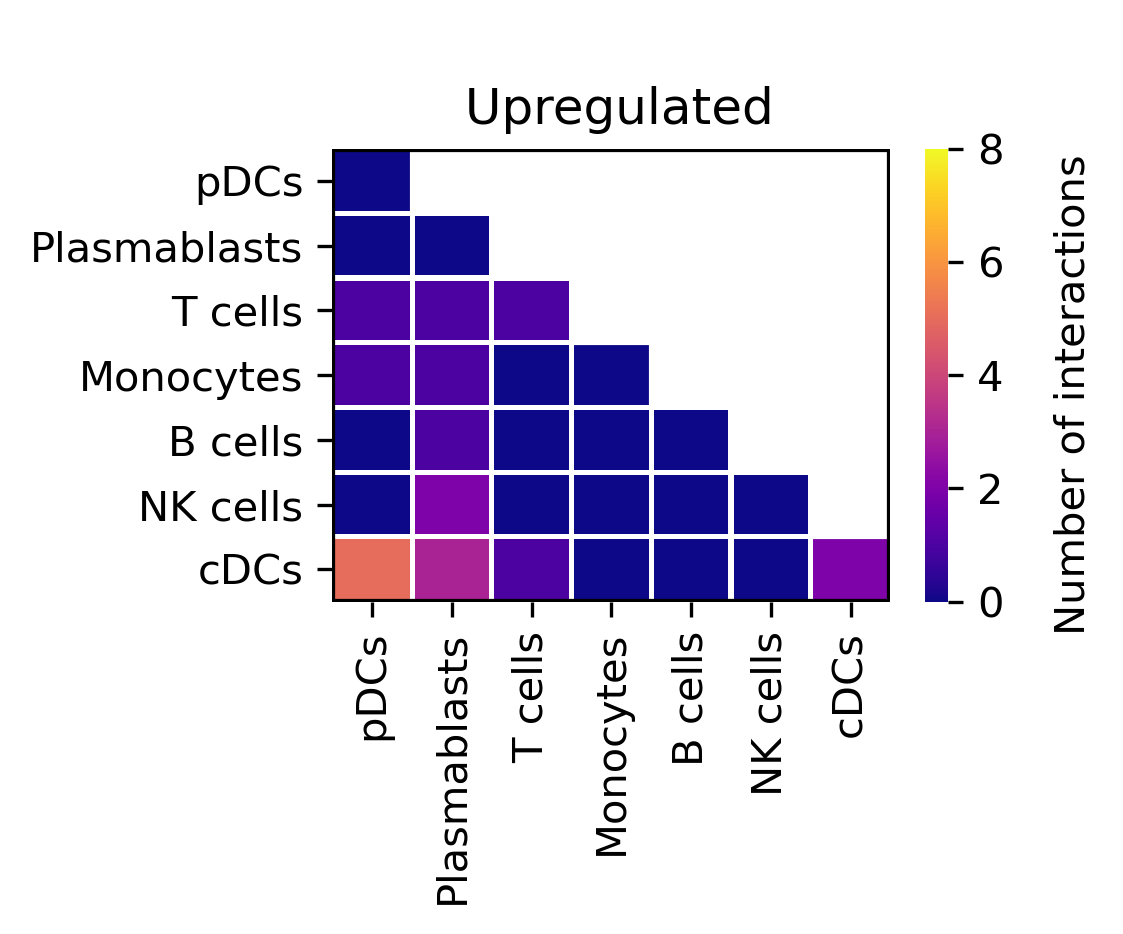

In [7]:
# from make_figure_functions import inter_number
# print('get heatmap showing the number of upregulated interactions')
# inter_number(up_up, 8, 'Up')

get heatmap showing the number of downregulated interactions


{'figure': <Figure size 900x600 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'\n Downregulated'}>}

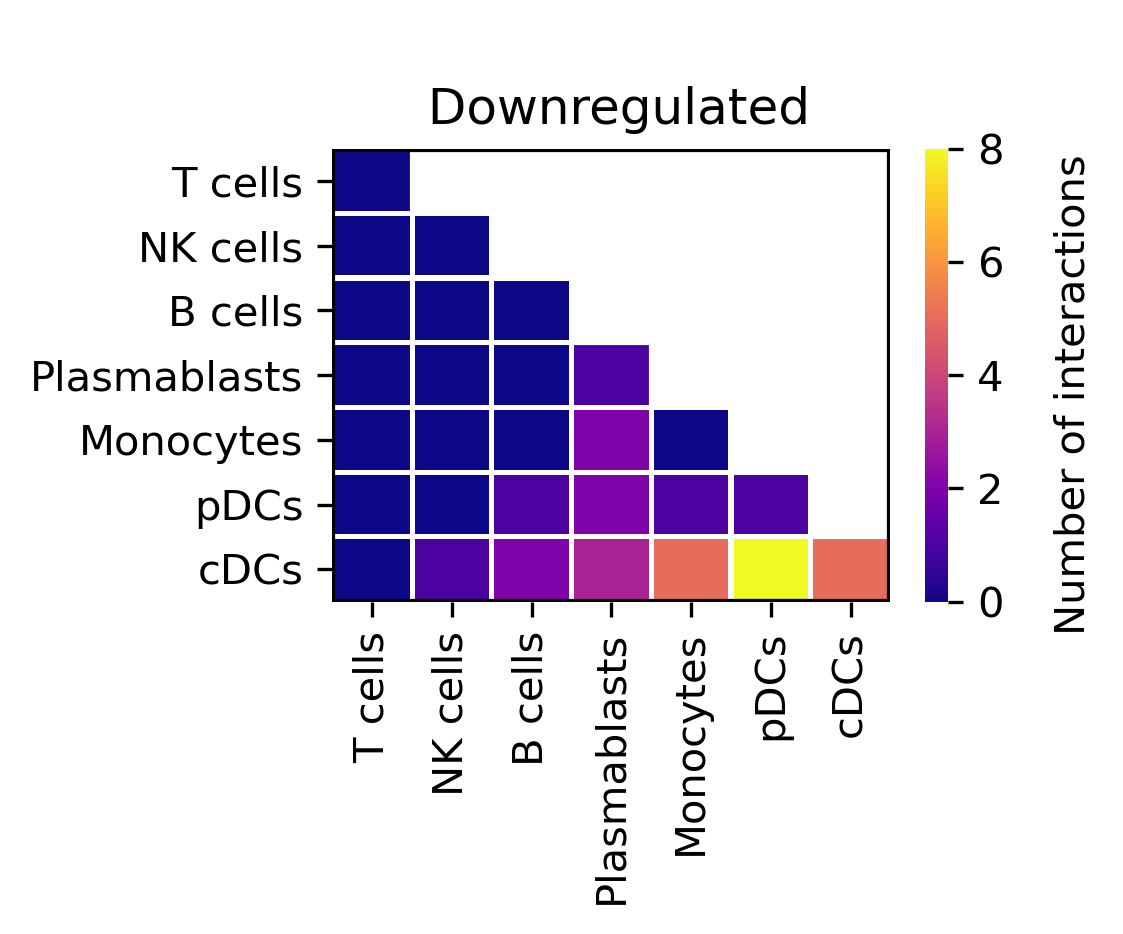

In [10]:
# print('get heatmap showing the number of downregulated interactions')
# inter_number(down_down, 8, 'Down')

get heatmap showing the number of mixregulated interactions


{'figure': <Figure size 900x600 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'Mixregulated'}>}

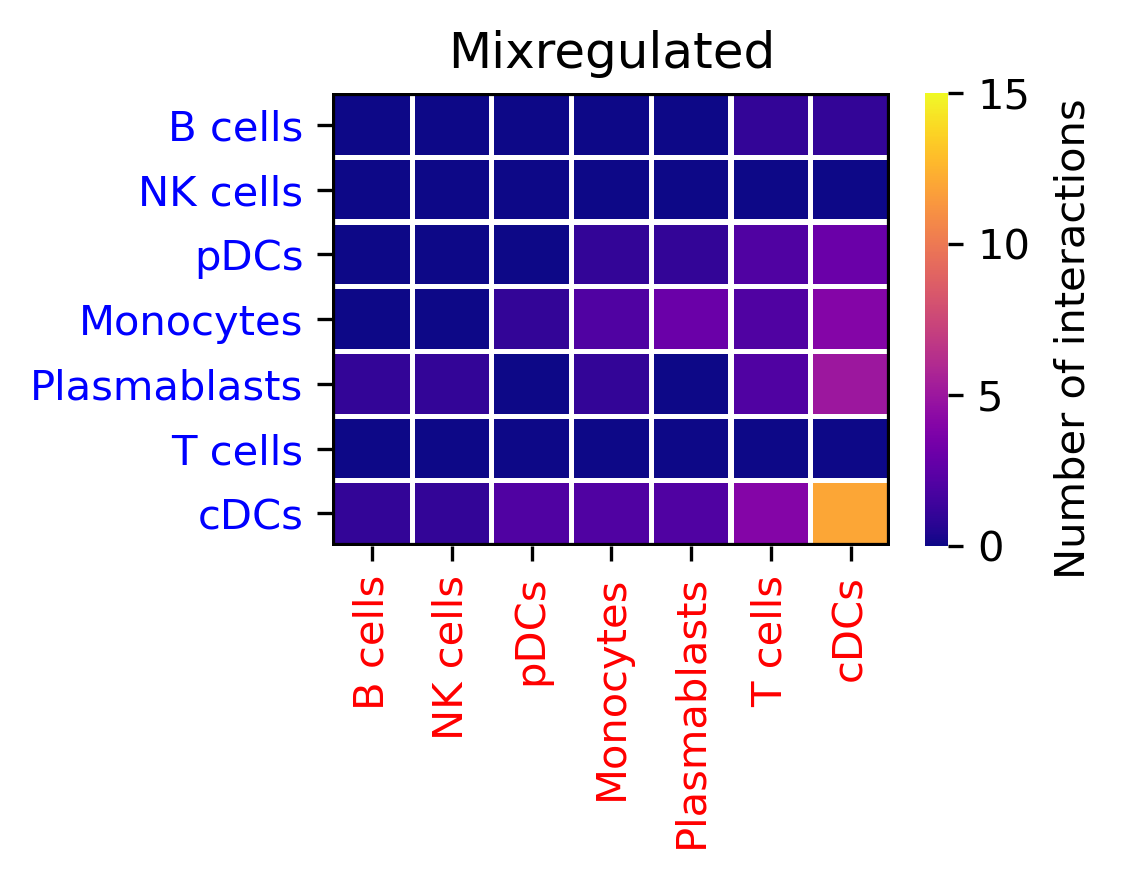

In [11]:
# from make_figure_functions import inter_mix_number
# print('get heatmap showing the number of mixregulated interactions')
# inter_mix_number(up_down, 15)

In [5]:
# up_up = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/upregulated_1_05_002.tsv')
# down_down = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/downregulated_1_05_002.tsv')
# up_down = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/mixregulated_1_05_002.tsv')